# 1 Data Acquisition, Cleaning & EDA

In this notebook, historic Forex data is acquired and pre-processed to better understand the nature of financial data. A range of techniques are employed to learn about the time series and an evaluation of pre-processing techniques is provided.

In [71]:
#import libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pandas_ta as ta
import seaborn as sns
import scipy.stats as scs

#Plot parameters
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.size'] = 13
plt.rcParams['axes.labelsize'] = 13
plt.rcParams['axes.titlesize'] = 17
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['font.family'] = 'serif'

## 1.1 Data Acquisition

After initial analysis, it was discovered that using major currency pairs such as the EUR/USD was inefficient due to the affect of big banks and whales. As a result, this notebook explores the AUD/USD dataset. This data was acquired from Dukaskopy, a swiss bank, in which daily currency data from 2011-2019 was pulled.

In [72]:
#read dataset in
df = pd.read_csv("./Data/AUDUSD_Candlestick_1_D_ASK_01.01.2011-01.01.2019.csv")

#index by date and reformat
df['Date'] = pd.to_datetime(df.Date, format="%d.%m.%Y %H:%M:%S.%f")

df['Date'] = pd.DataFrame(df.Date).applymap(lambda x: x.date())

df = df.set_index(df.Date).drop(columns=['Date'])

#Calculate simple return from closing prices
df['Return'] = df['Close'].pct_change()

df = df[['Open', 'High', 'Low', 'Close', 'Volume', 'Return']]

#Drop duplicates
df = df.drop_duplicates(keep=False)

#Remove 0 volume trading days
df = df[df.Volume != 0]


df

Open     High      Low    Close       Volume    Return
Date                                                                 
2011-01-02  1.02070  1.02267  1.01582  1.01687   69778.4109 -0.005808
2011-01-03  1.01687  1.01716  1.00294  1.00517  124906.5397 -0.011506
2011-01-04  1.00517  1.00770  0.99613  0.99961  119343.0942 -0.005531
2011-01-05  0.99961  1.00159  0.99338  0.99449   99106.5343 -0.005122
2011-01-06  0.99448  0.99932  0.99087  0.99614  101413.4171  0.001659
...             ...      ...      ...      ...          ...       ...
2018-12-25  0.70428  0.70723  0.70333  0.70693   77848.7096  0.003848
2018-12-26  0.70693  0.70786  0.70173  0.70352  193196.9914 -0.004824
2018-12-27  0.70338  0.70698  0.70287  0.70412  147956.1087  0.000853
2018-12-30  0.70450  0.70721  0.70334  0.70534  108426.1493  0.001733
2019-01-01  0.70542  0.70554  0.69826  0.69853  190119.7498 -0.009655

[2091 rows x 6 columns]

In [73]:
df.describe()

Open         High          Low        Close         Volume  \
count  2091.000000  2091.000000  2091.000000  2091.000000    2091.000000   
mean      0.869584     0.873584     0.864995     0.869470  136658.661694   
std       0.126997     0.127459     0.126249     0.127009   79790.386671   
min       0.684140     0.692600     0.682780     0.686530    2514.350100   
25%       0.756055     0.758520     0.752405     0.755695   95757.749900   
50%       0.818440     0.821870     0.812870     0.817290  120091.931000   
75%       1.008290     1.013265     1.001520     1.008180  152584.624750   
max       1.103220     1.108100     1.097730     1.102510  741490.072900   

            Return  
count  2091.000000  
mean     -0.000160  
std       0.006446  
min      -0.029889  
25%      -0.003936  
50%       0.000000  
75%       0.003751  
max       0.031796

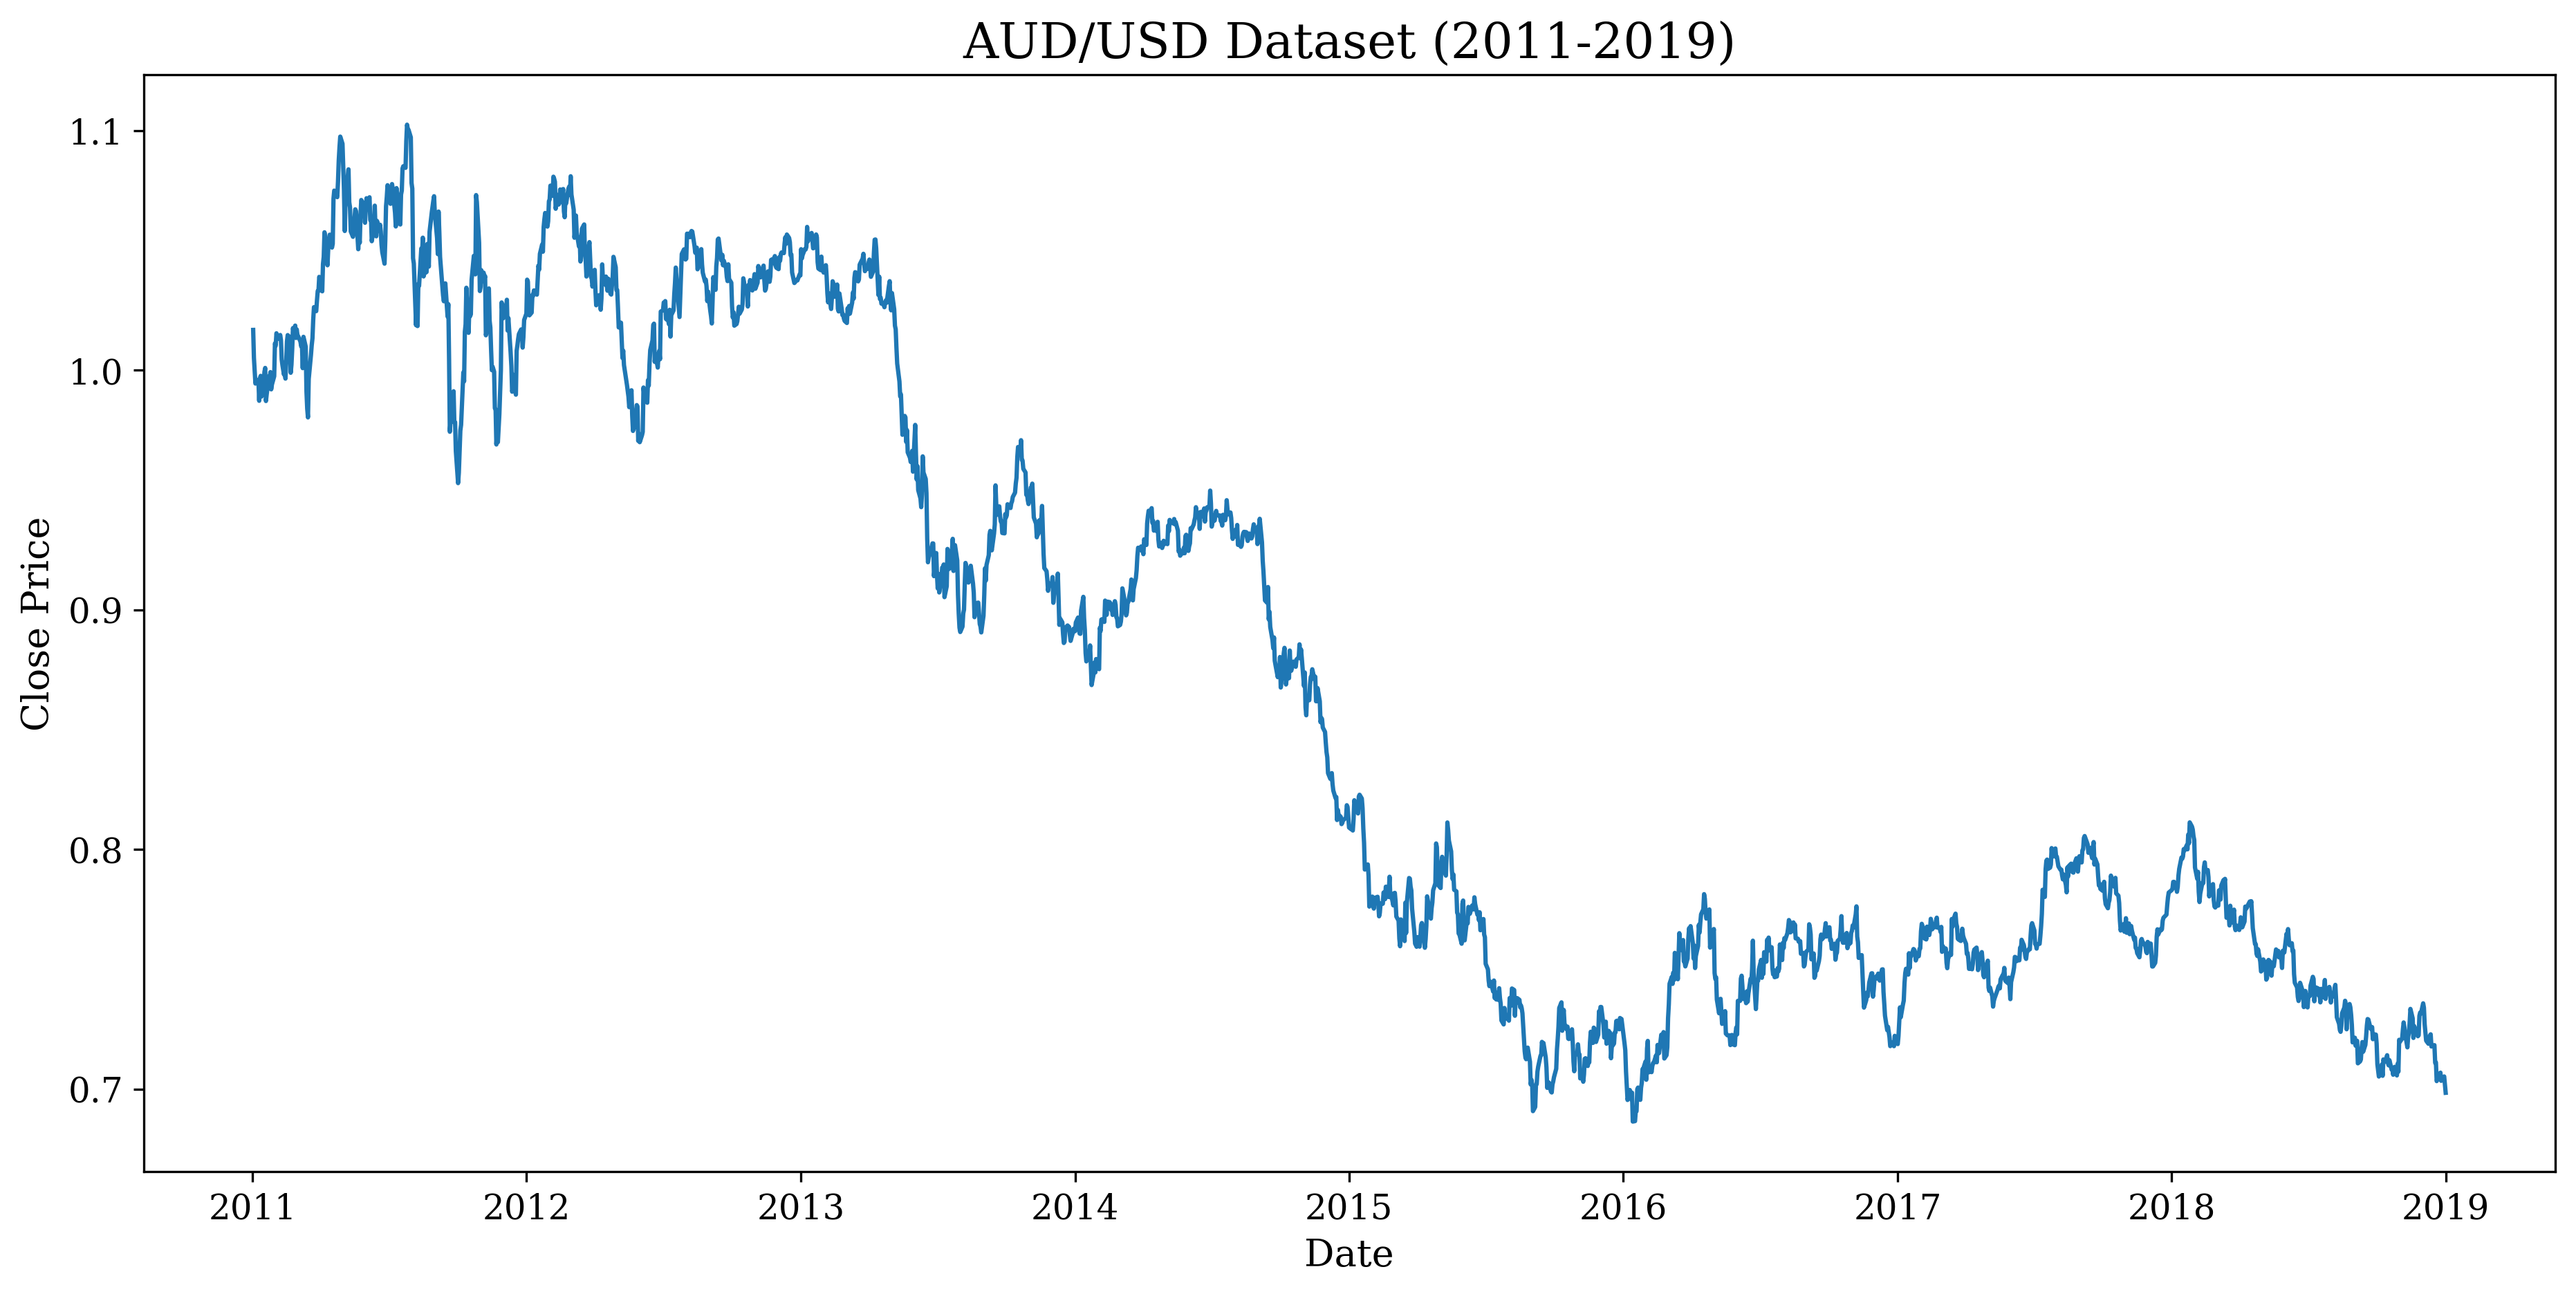

In [74]:
#Plot data
fig, ax = plt.subplots(figsize=(15,7))
ax.set_title("AUD/USD Dataset (2011-2019)")
ax.set_ylabel("Close Price")
ax.set_xlabel("Date")
ax.plot(df.Close)

## 1.2 Identifying Outliers

Here, methods are employed to identify and remove noise from the dataset. The first method used included finding values outside of n-standard deviations of the mean. This is generally naive approach to outlier detection as it discriminates to the context of movements in the series however provides a good approximation of certain outliers when the correct number of standard deviations is used.

mean   -0.000160
std     0.006446
Name: Return, dtype: float64


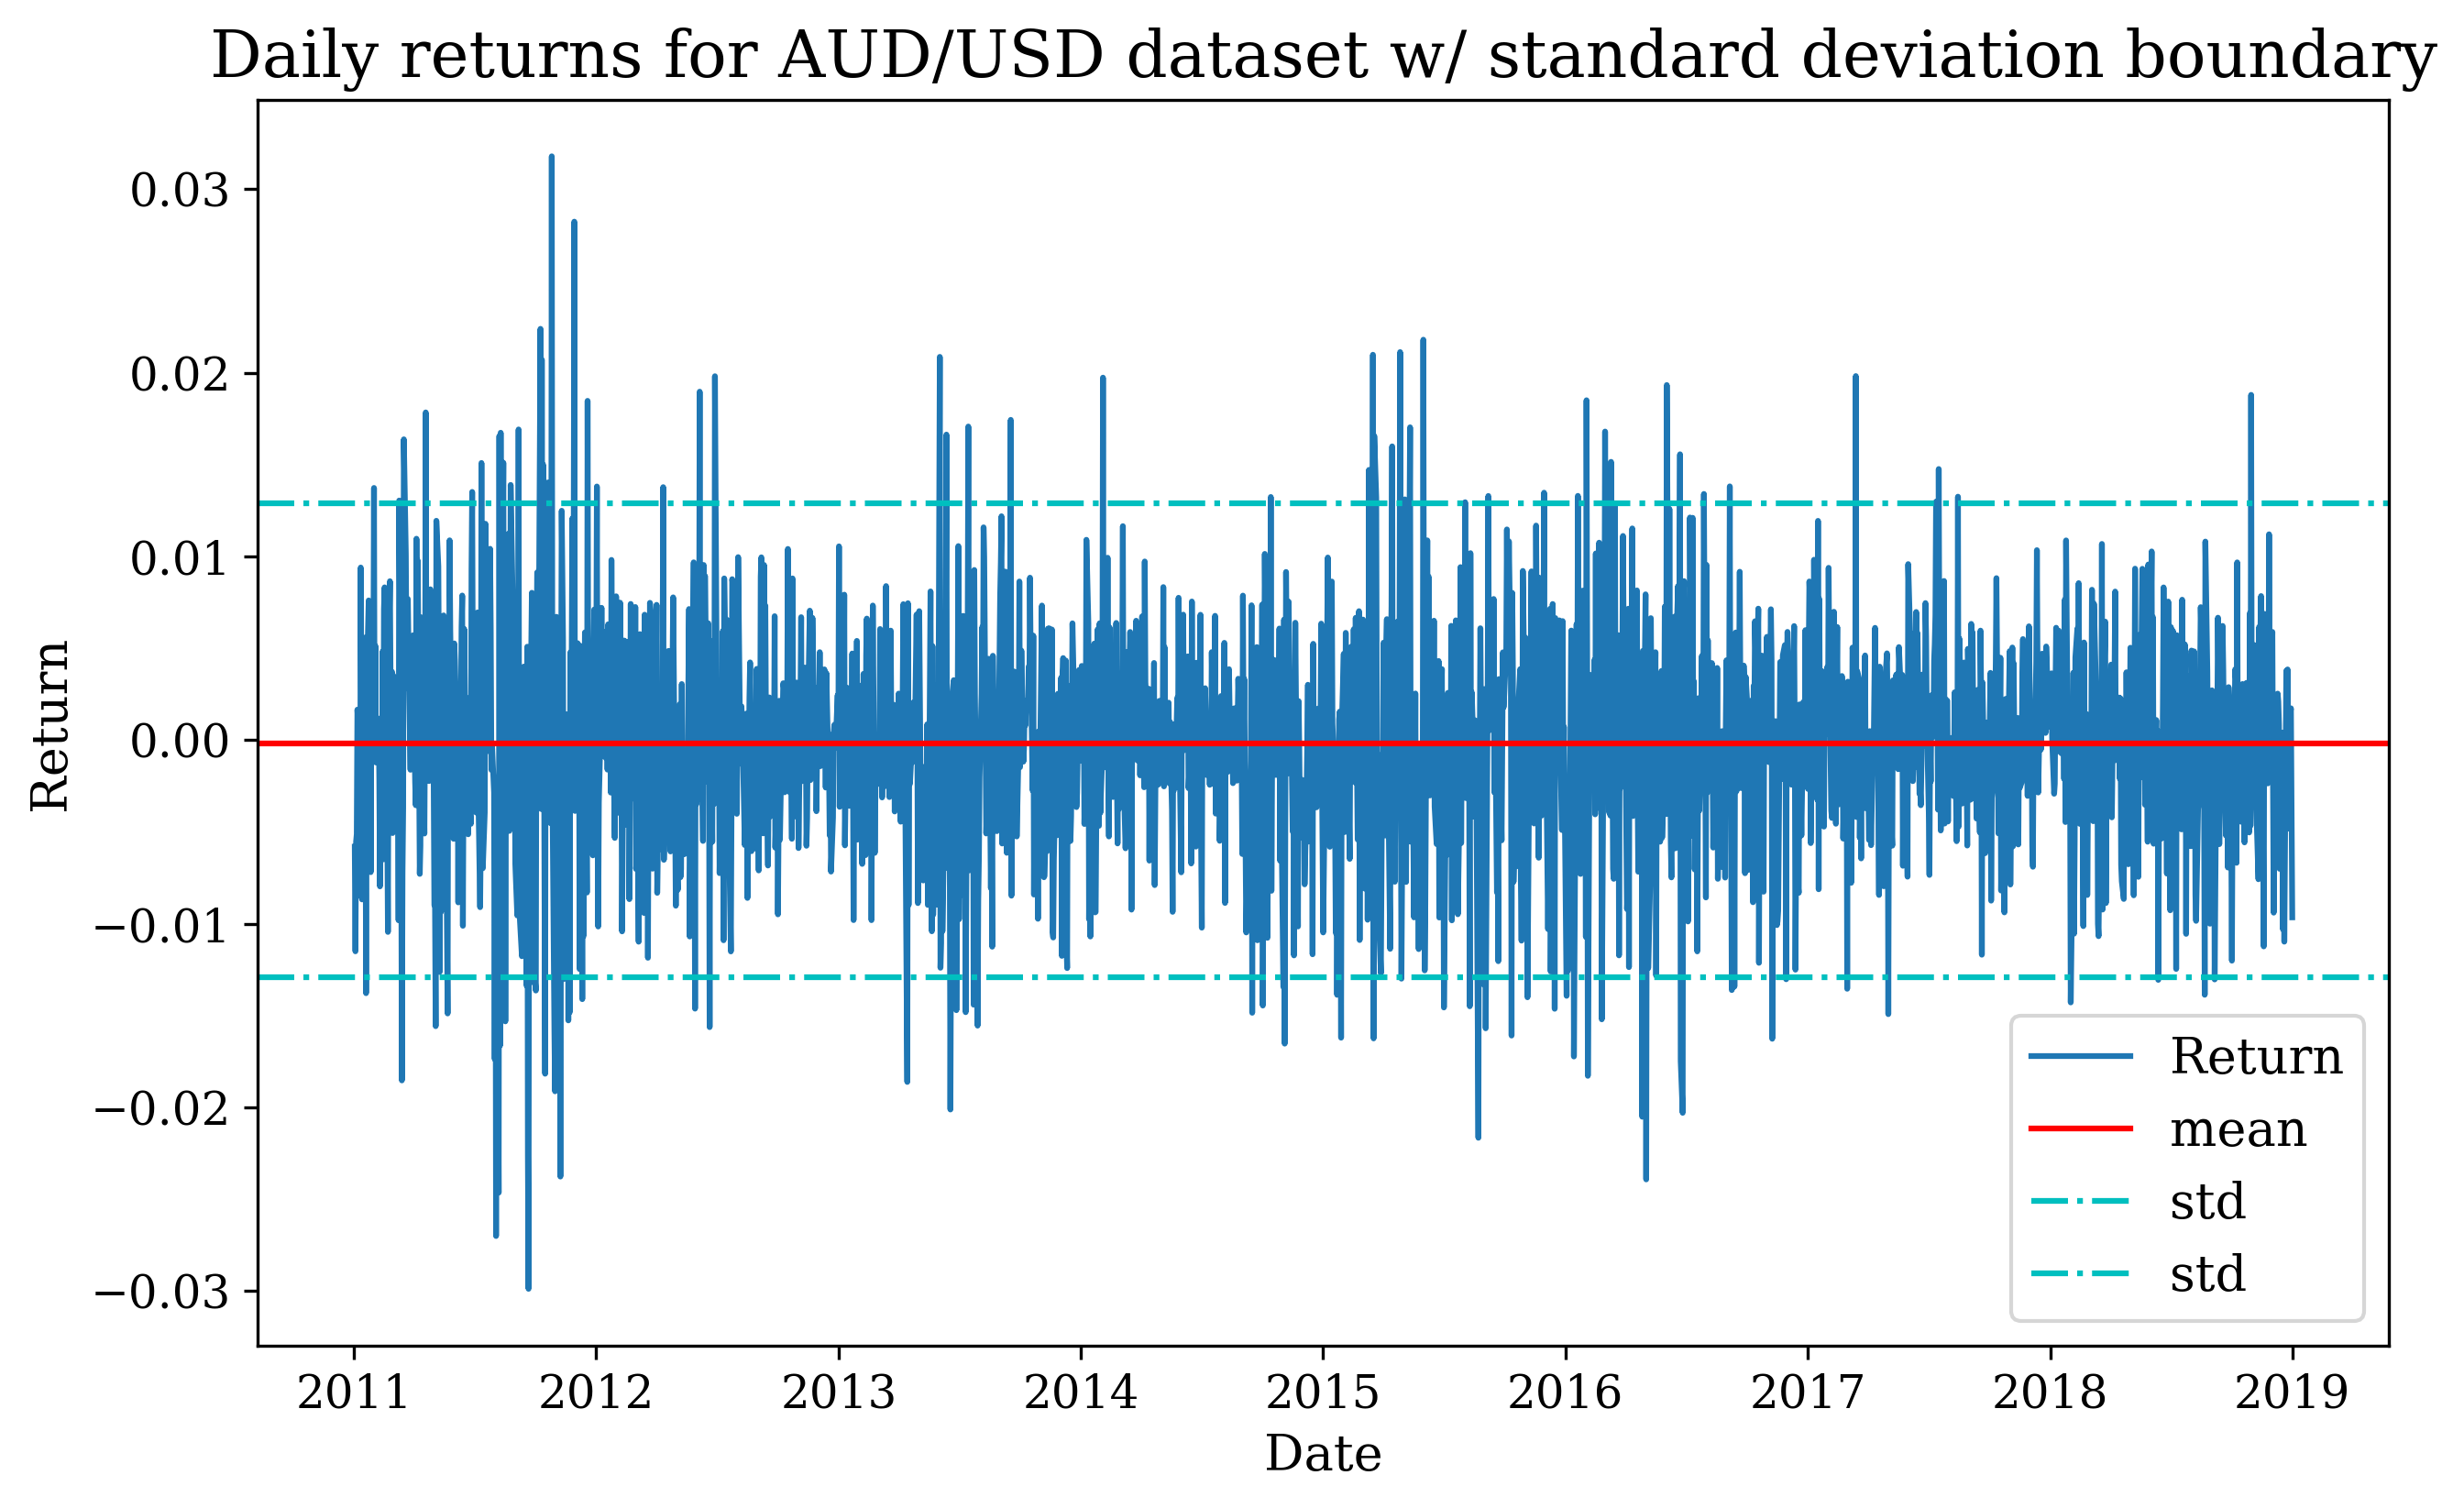

In [75]:
#define boundary using mean and standard deviation of data
def plot_std_outlier_detection(df,num_std=2):
    """
    :param df: dataset of OHLC prices
    :param num_std: number of standard deviations of mean to use as decision boundary
    """
    df_mean = df['Return'].agg(['mean', 'std'])

    print(df_mean)
    
    fig, ax = plt.subplots(figsize=(10,6))

    df['Return'].plot(label='Return', legend=True, ax=ax)

    ax.axhline(y=df_mean.loc['mean'], c='r', label='mean')

    ax.axhline(y=num_std*df_mean.loc['std'], c='c', linestyle='-.', label='std')

    ax.axhline(y=num_std*-df_mean.loc['std'], c='c', linestyle='-.',label='std')

    ax.set_title("Daily returns for AUD/USD dataset w/ standard deviation boundary")
    ax.set_ylabel("Return")
    ax.set_xlabel("Date")

    ax.legend(loc='lower right')
    
    return df_mean
    
df_mean_og = plot_std_outlier_detection(df,2)

Another outlier detection method involves moving averages of return with a rolling mean and standard deviation. The intuition behind this technique is to better capture the context of the dataset to provide a more accurate detection mechanism.

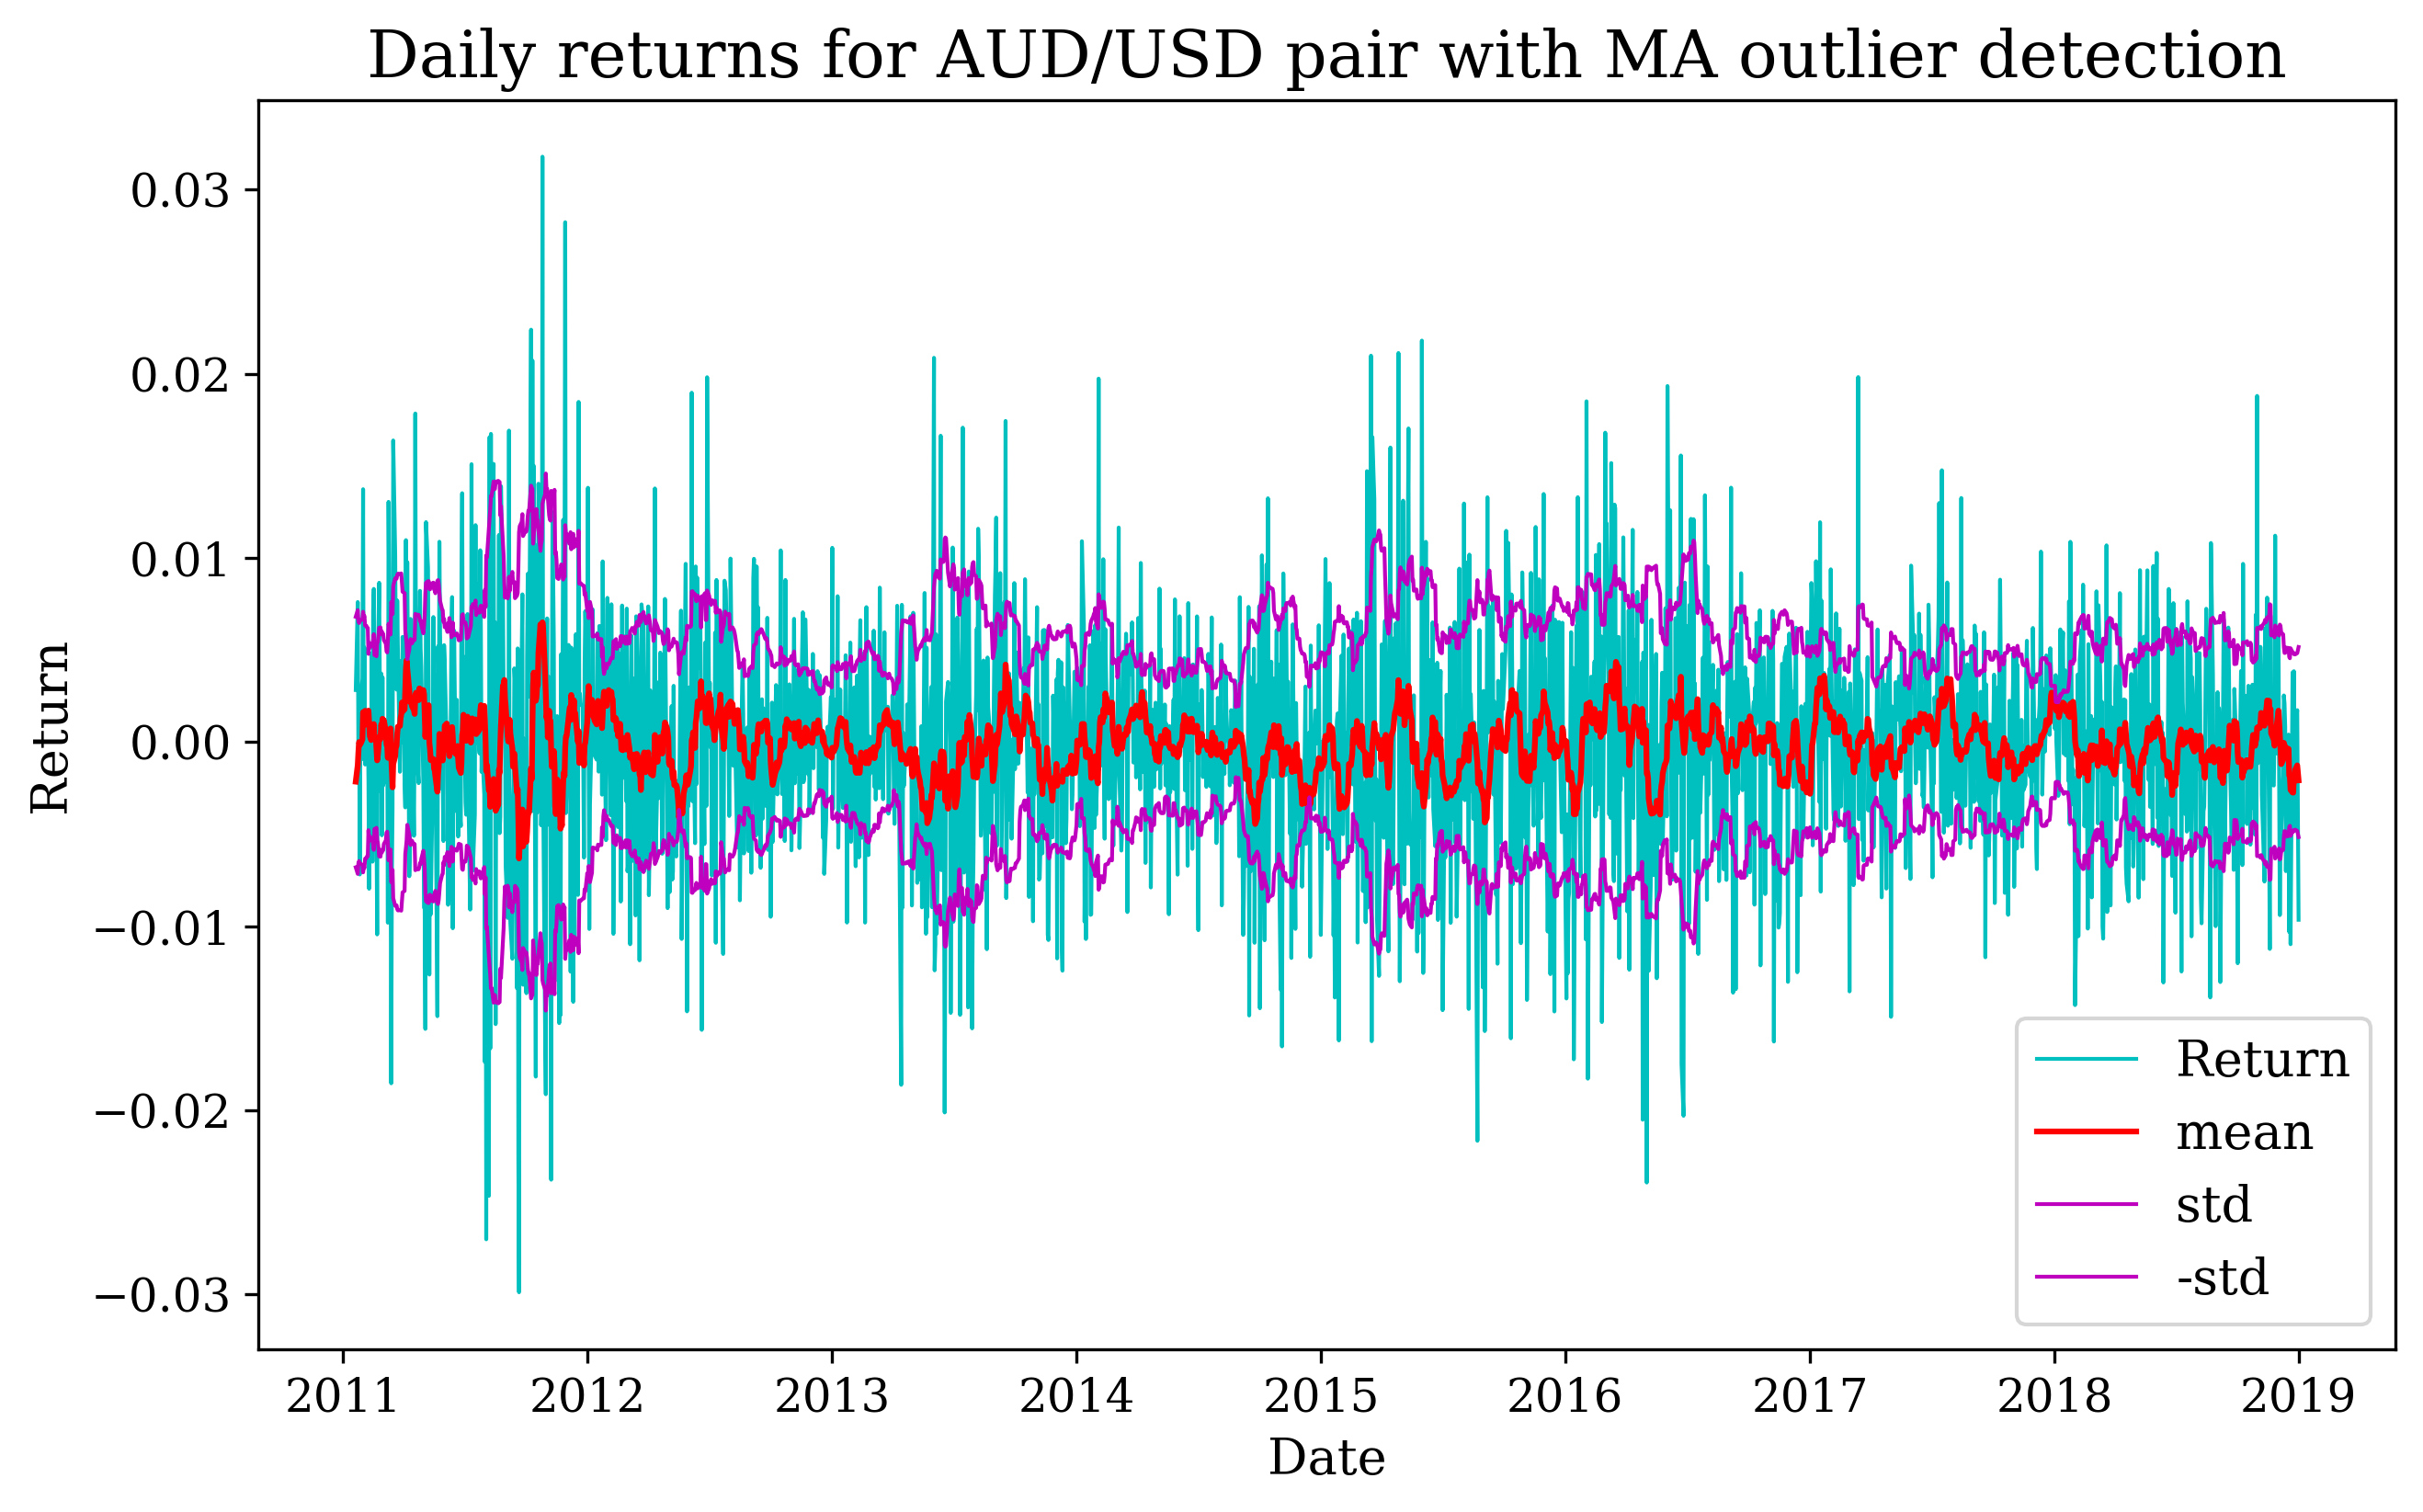

In [76]:
#for moving averages boundary
def plot_std_ma_outlier_detection(df, period, num_std):
    """
    :param df: dataset of OHLC prices
    :param period: number of observations used when calculating moving averages
    :param num_std: number of standard deviations of mean to use as decision boundary
    """  
    df_mean = df.copy()
    df_mean[['mean','std']] = df['Return'].rolling(window=period).agg(['mean', 'std']).astype(float)
    df_mean.dropna(inplace=True)
    
    fig, ax = plt.subplots(figsize=(10,6))

    ax.plot(df_mean.index, df_mean['Return'], label='Return',c='c', lw=1)
    ax.plot(df_mean.index, df_mean['mean'], label= 'mean',c='r')
    ax.plot(df_mean.index, num_std*df_mean[ 'std'], label= 'std',linestyle='-',c='m', lw=1 )
    ax.plot(df_mean.index, -num_std*df_mean['std'],label='-std', linestyle='-',c='m', lw=1)

    ax.set_title("Daily returns for AUD/USD pair with MA outlier detection")
    ax.set_xlabel("Date")
    ax.set_ylabel("Return")
    
    ax.legend(loc='lower right')
    
    return df_mean

df_mean_new = plot_std_ma_outlier_detection(df, 15, 1)

## 1.3 Plotting Outliers

In [77]:
mean_val = df_mean_og.loc['mean']

std_val = df_mean_og.loc['std']

#Getting outliers from normal standard deviation boundary
def get_outliers(df, mean=mean_val, std=std_val, n_std=2):
    '''
    df: dataframe of OHLC prices
    mean: mean series
    std: standard deviation values
    n_sigmas: number of std as boundary
    '''
    
    x = df['Return']
    
    if (x > mean+n_std*std) | (x<mean-n_std*std):
        
        return 1
    
    else:
        
        return 0

df['Outlier'] = df.apply(get_outliers, axis=1)

print("Detected outliers for AUD/USD dataset using standard deviation boundary:")
print(df.Outlier.value_counts())

Detected outliers for AUD/USD dataset using standard deviation boundary:
0    1977
1     114
Name: Outlier, dtype: int64


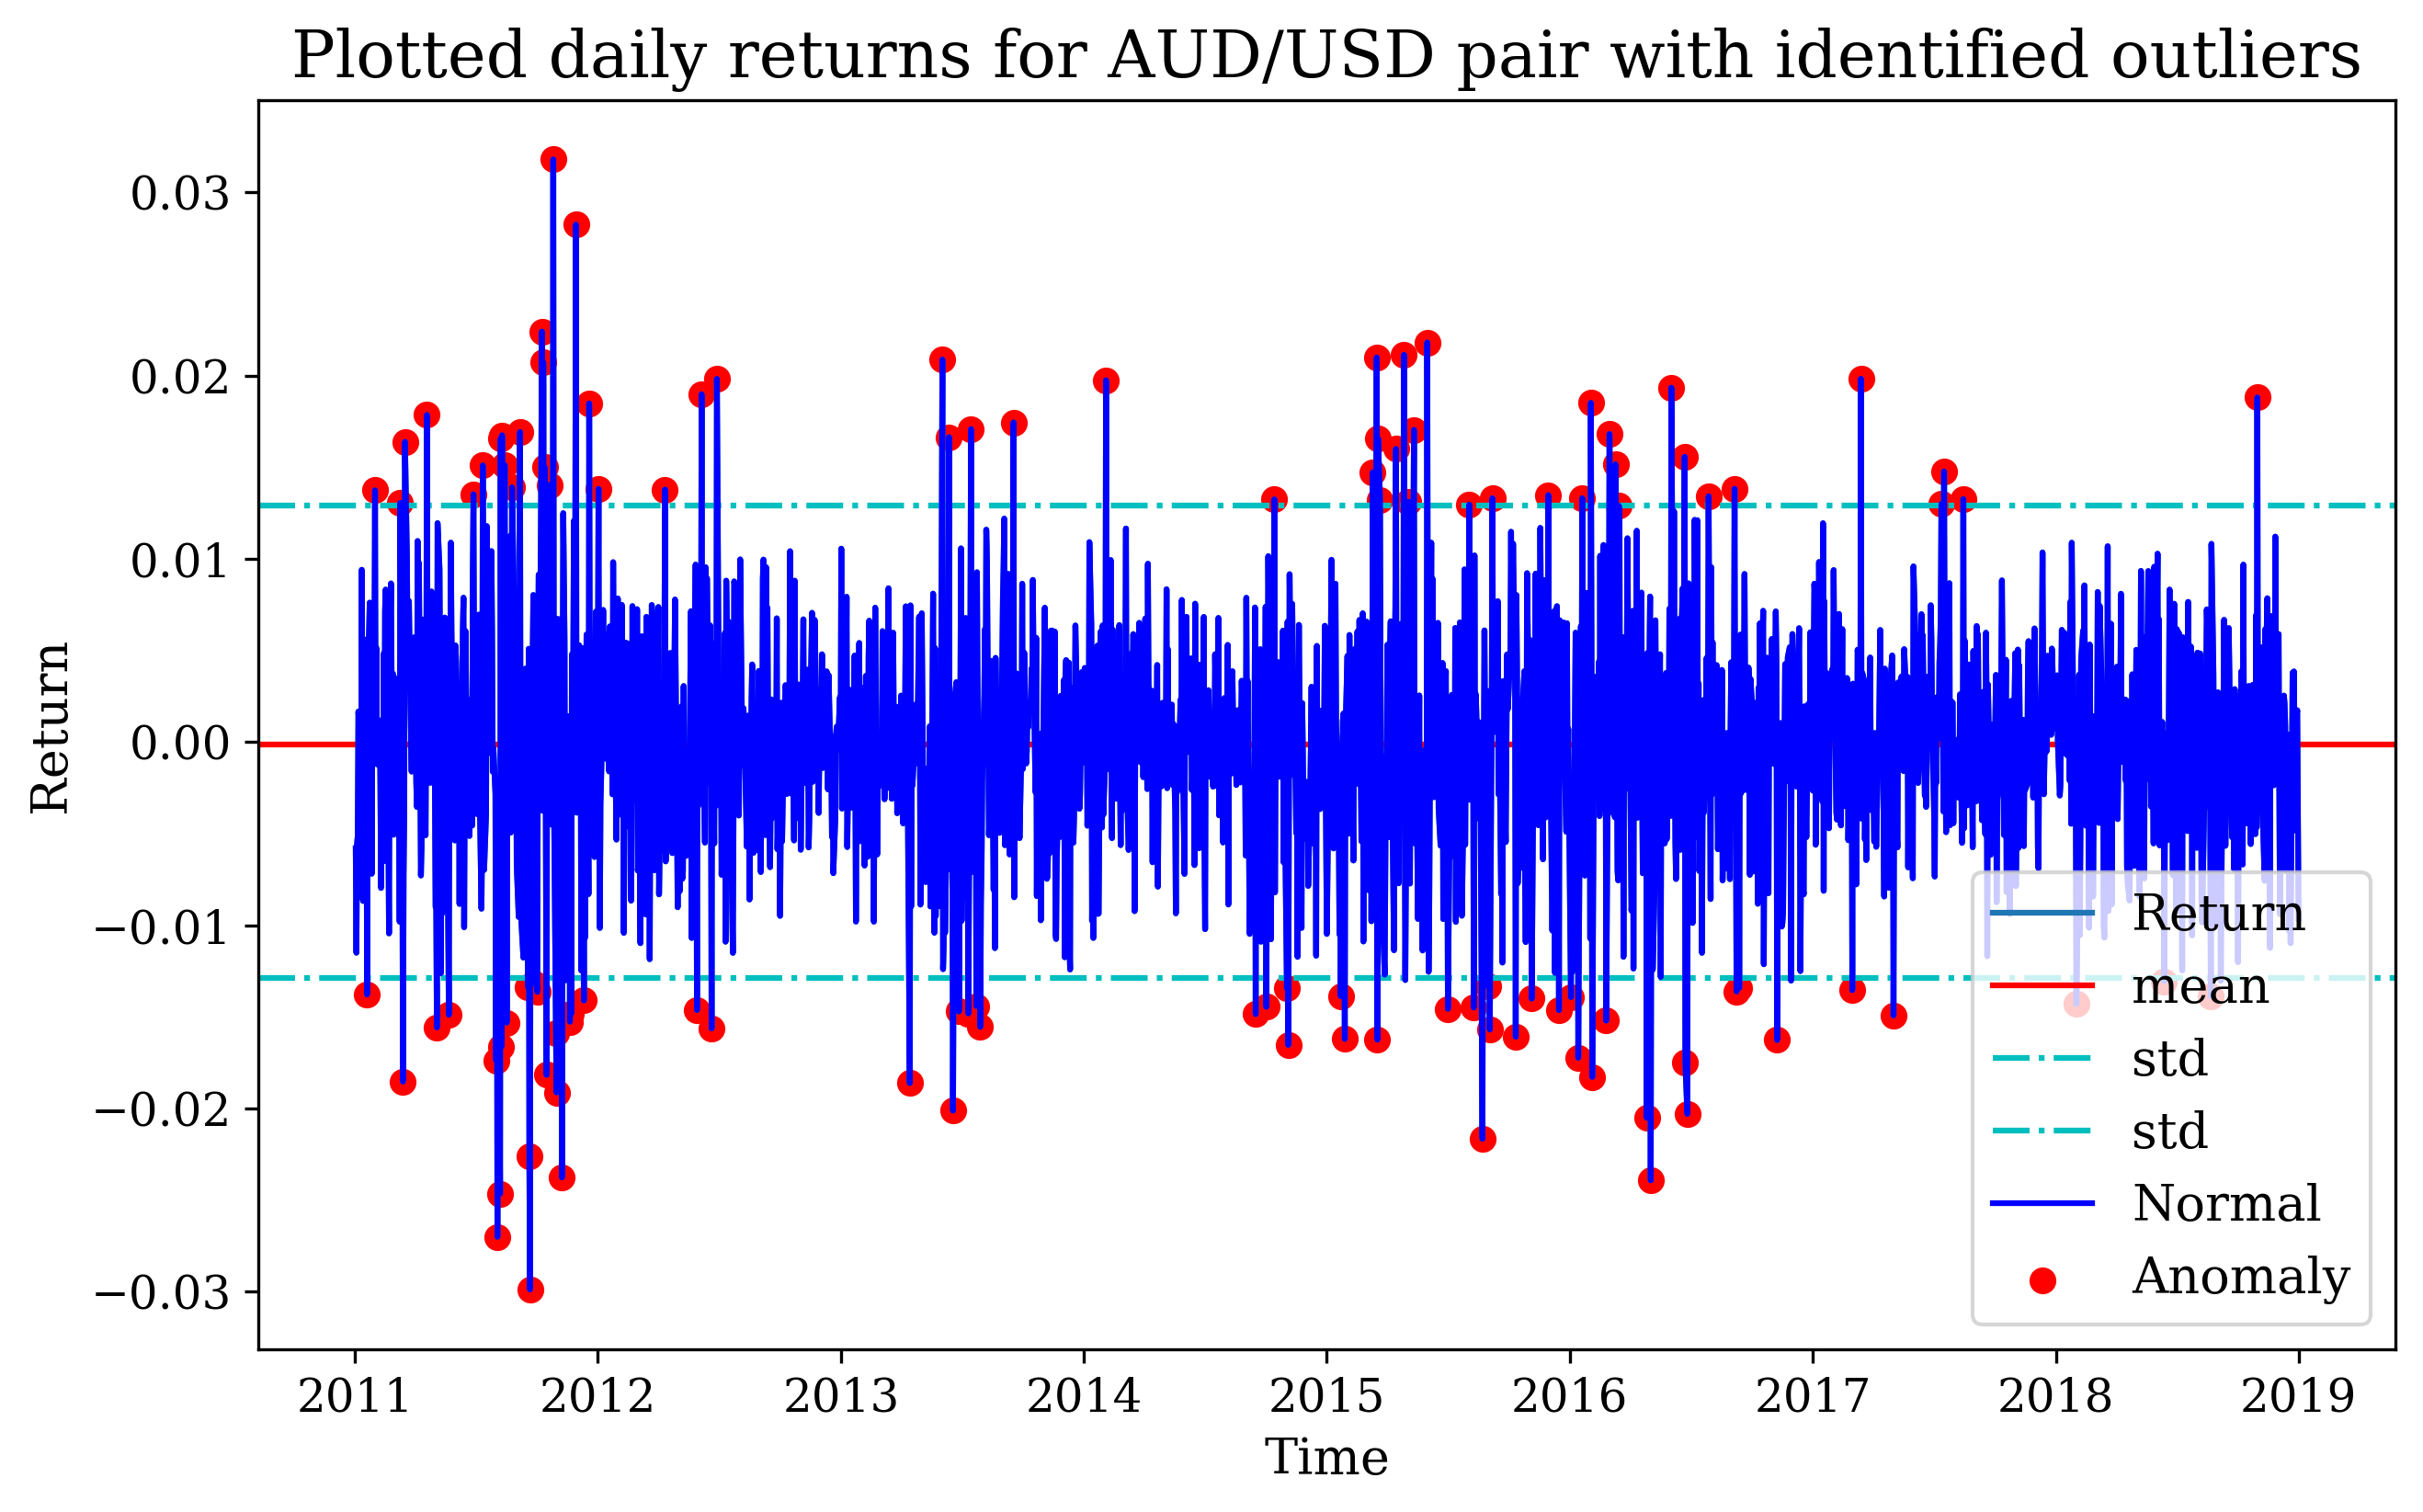

In [78]:
#Plot outliers
outliers = df.loc[df['Outlier'] == 1, ['Return']]

#plot data + boundaries using 3 times the standard deviation as outer boundary
fig, ax = plt.subplots(figsize=(10,6))

df['Return'].plot(label='Return', legend=True, ax=ax)

ax.axhline(y=df_mean_og.loc['mean'], c='r', label='mean')

ax.axhline(y=2*df_mean_og.loc['std'], c='c', linestyle='-.', label='std')

ax.axhline(y=2*-df_mean_og.loc['std'], c='c', linestyle='-.',label='std')

plt.title("Plotted daily returns for AUD/USD pair with identified outliers")
plt.xlabel("Time")
plt.ylabel("Return")

ax.plot(df.index, df.Return, 
        color='blue', label='Normal')

ax.scatter(outliers.index, outliers.Return, 
           color='red', label='Anomaly')

plt.legend(loc='lower right')

plt.show()

In [79]:
#Getting outliers from moving average standard deviation boundary
def get_outliers_ma(df, n_std=2):
    '''
    df: dataframe of OHLC prices with rolling mean and std series
    '''
    find_outliers = df[(df['Return'] > (df['mean'] + n_std * df['std'])) | (df['Return'] < (df['mean'] - n_std * df['std']))]

    return find_outliers.index
    
indexes = get_outliers_ma(df_mean_new, 2).tolist()
outliers = pd.DataFrame(df_mean_new.index).applymap(lambda x: 1 if x in indexes else 0)
df_mean_new['Outlier'] = outliers.values

print("Detected outliers for AUD/USD dataset using moving average standard deviation boundary:")
df_mean_new.Outlier.value_counts()

Detected outliers for AUD/USD dataset using moving average standard deviation boundary:


0    1999
1      78
Name: Outlier, dtype: int64

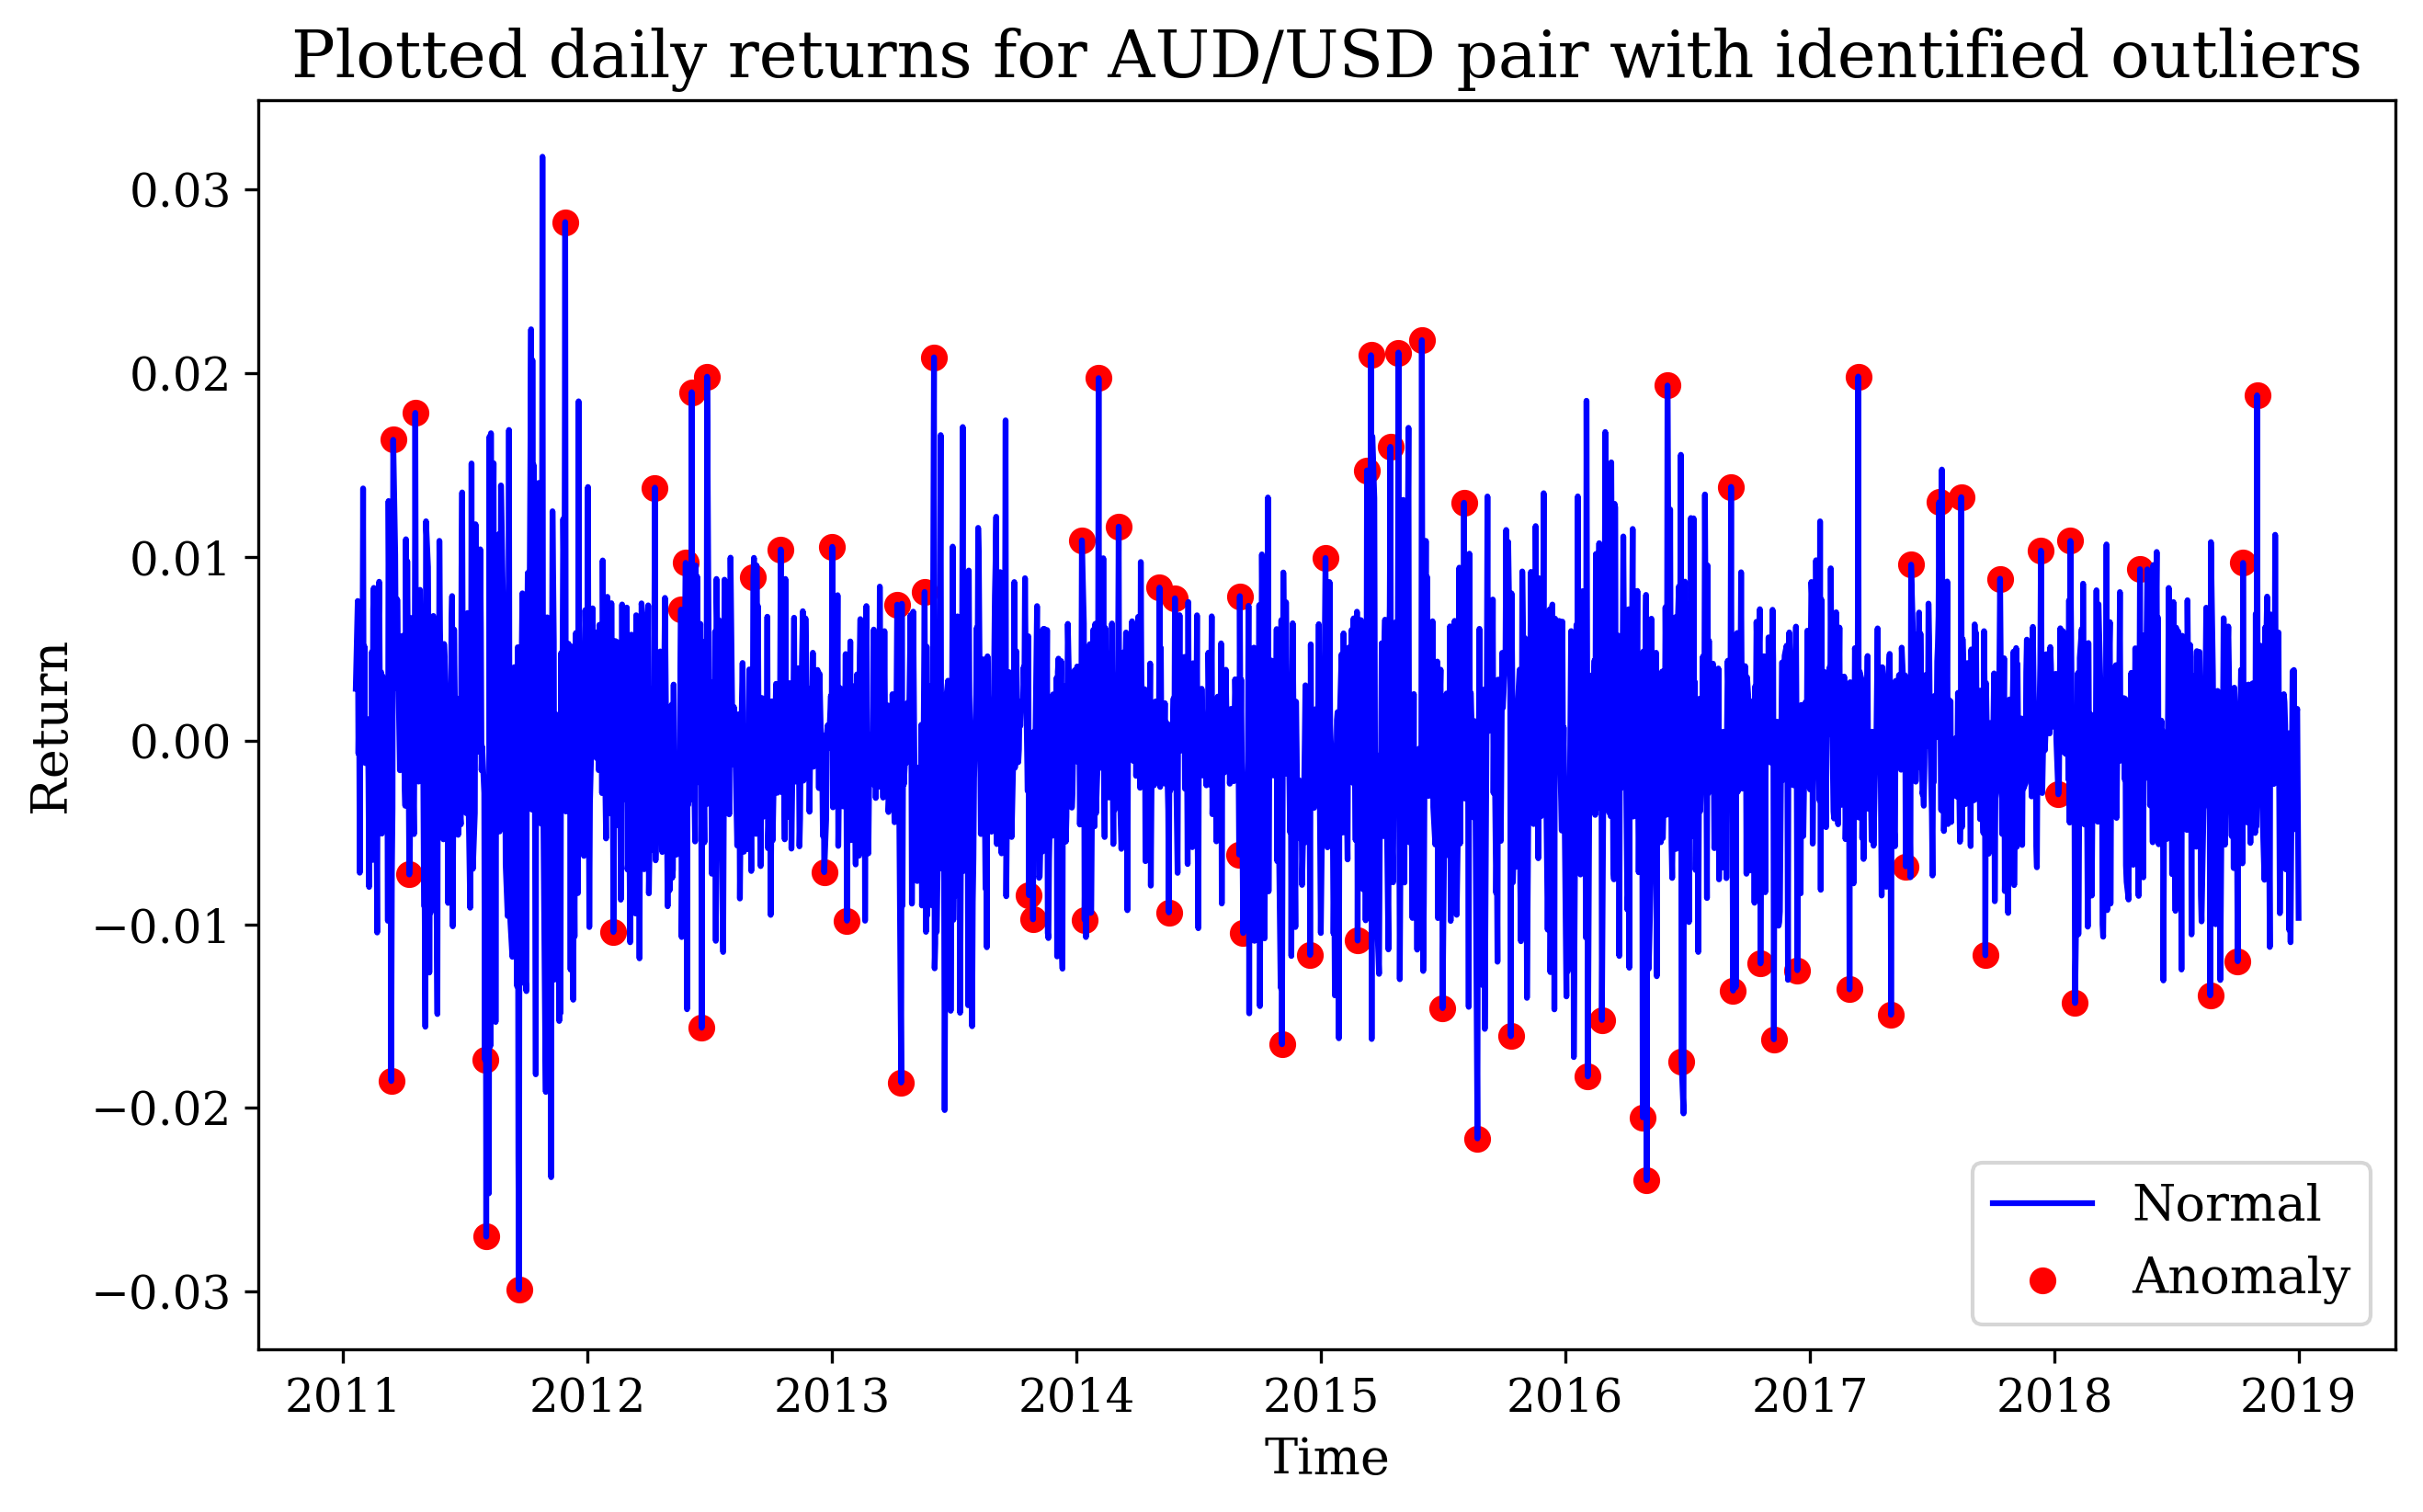

In [80]:
#Plot outliers for ma boundary
outliers = df_mean_new.loc[df['Outlier'] == 1, ['Return']]

#plot data + boundaries using 3 times the standard deviation as outer boundary
fig, ax = plt.subplots(figsize=(10,6))

plt.title("Plotted daily returns for AUD/USD pair with identified outliers")
plt.xlabel("Time")
plt.ylabel("Return")

ax.plot(df_mean_new.index, df_mean_new.Return, 
        color='blue', label='Normal')

ax.scatter(df_mean_new[df_mean_new['Outlier'] == 1].index, df_mean_new[df_mean_new['Outlier'] == 1].Return, 
           color='red', label='Anomaly')

plt.legend(loc='lower right')

plt.show()

It can be observed that the naive approach to outlier detection through rigid standard deviation boundaries was more sensitive and detected more anomalis.

## 1.4 Winsorization

Winsorization is the process of replacing a number of outlier values with smaller values. It performs the same way as clipping within signal processing and fortunately pandas has a dedicated library for this purpose. This is beneficial as it allows for the retention of the entire time series through the adjustment of values, however, can result in the removal of important trends within the data.

In [81]:
#perform winsorization to clip outlier values to smaller values within data range
def winsorization(df, cutoff):
    '''
    param df: dataframe of OHLC 
    param cutoff: define the percentile at which to set outliers to
    '''
    df_new = df.copy()
    
    df_new.pipe(lambda x: x.clip(lower=x.quantile(cutoff), upper=x.quantile(1-cutoff), axis=1, inplace=True))
    
    return df_new

winzor_df = winsorization(df, 0.01)

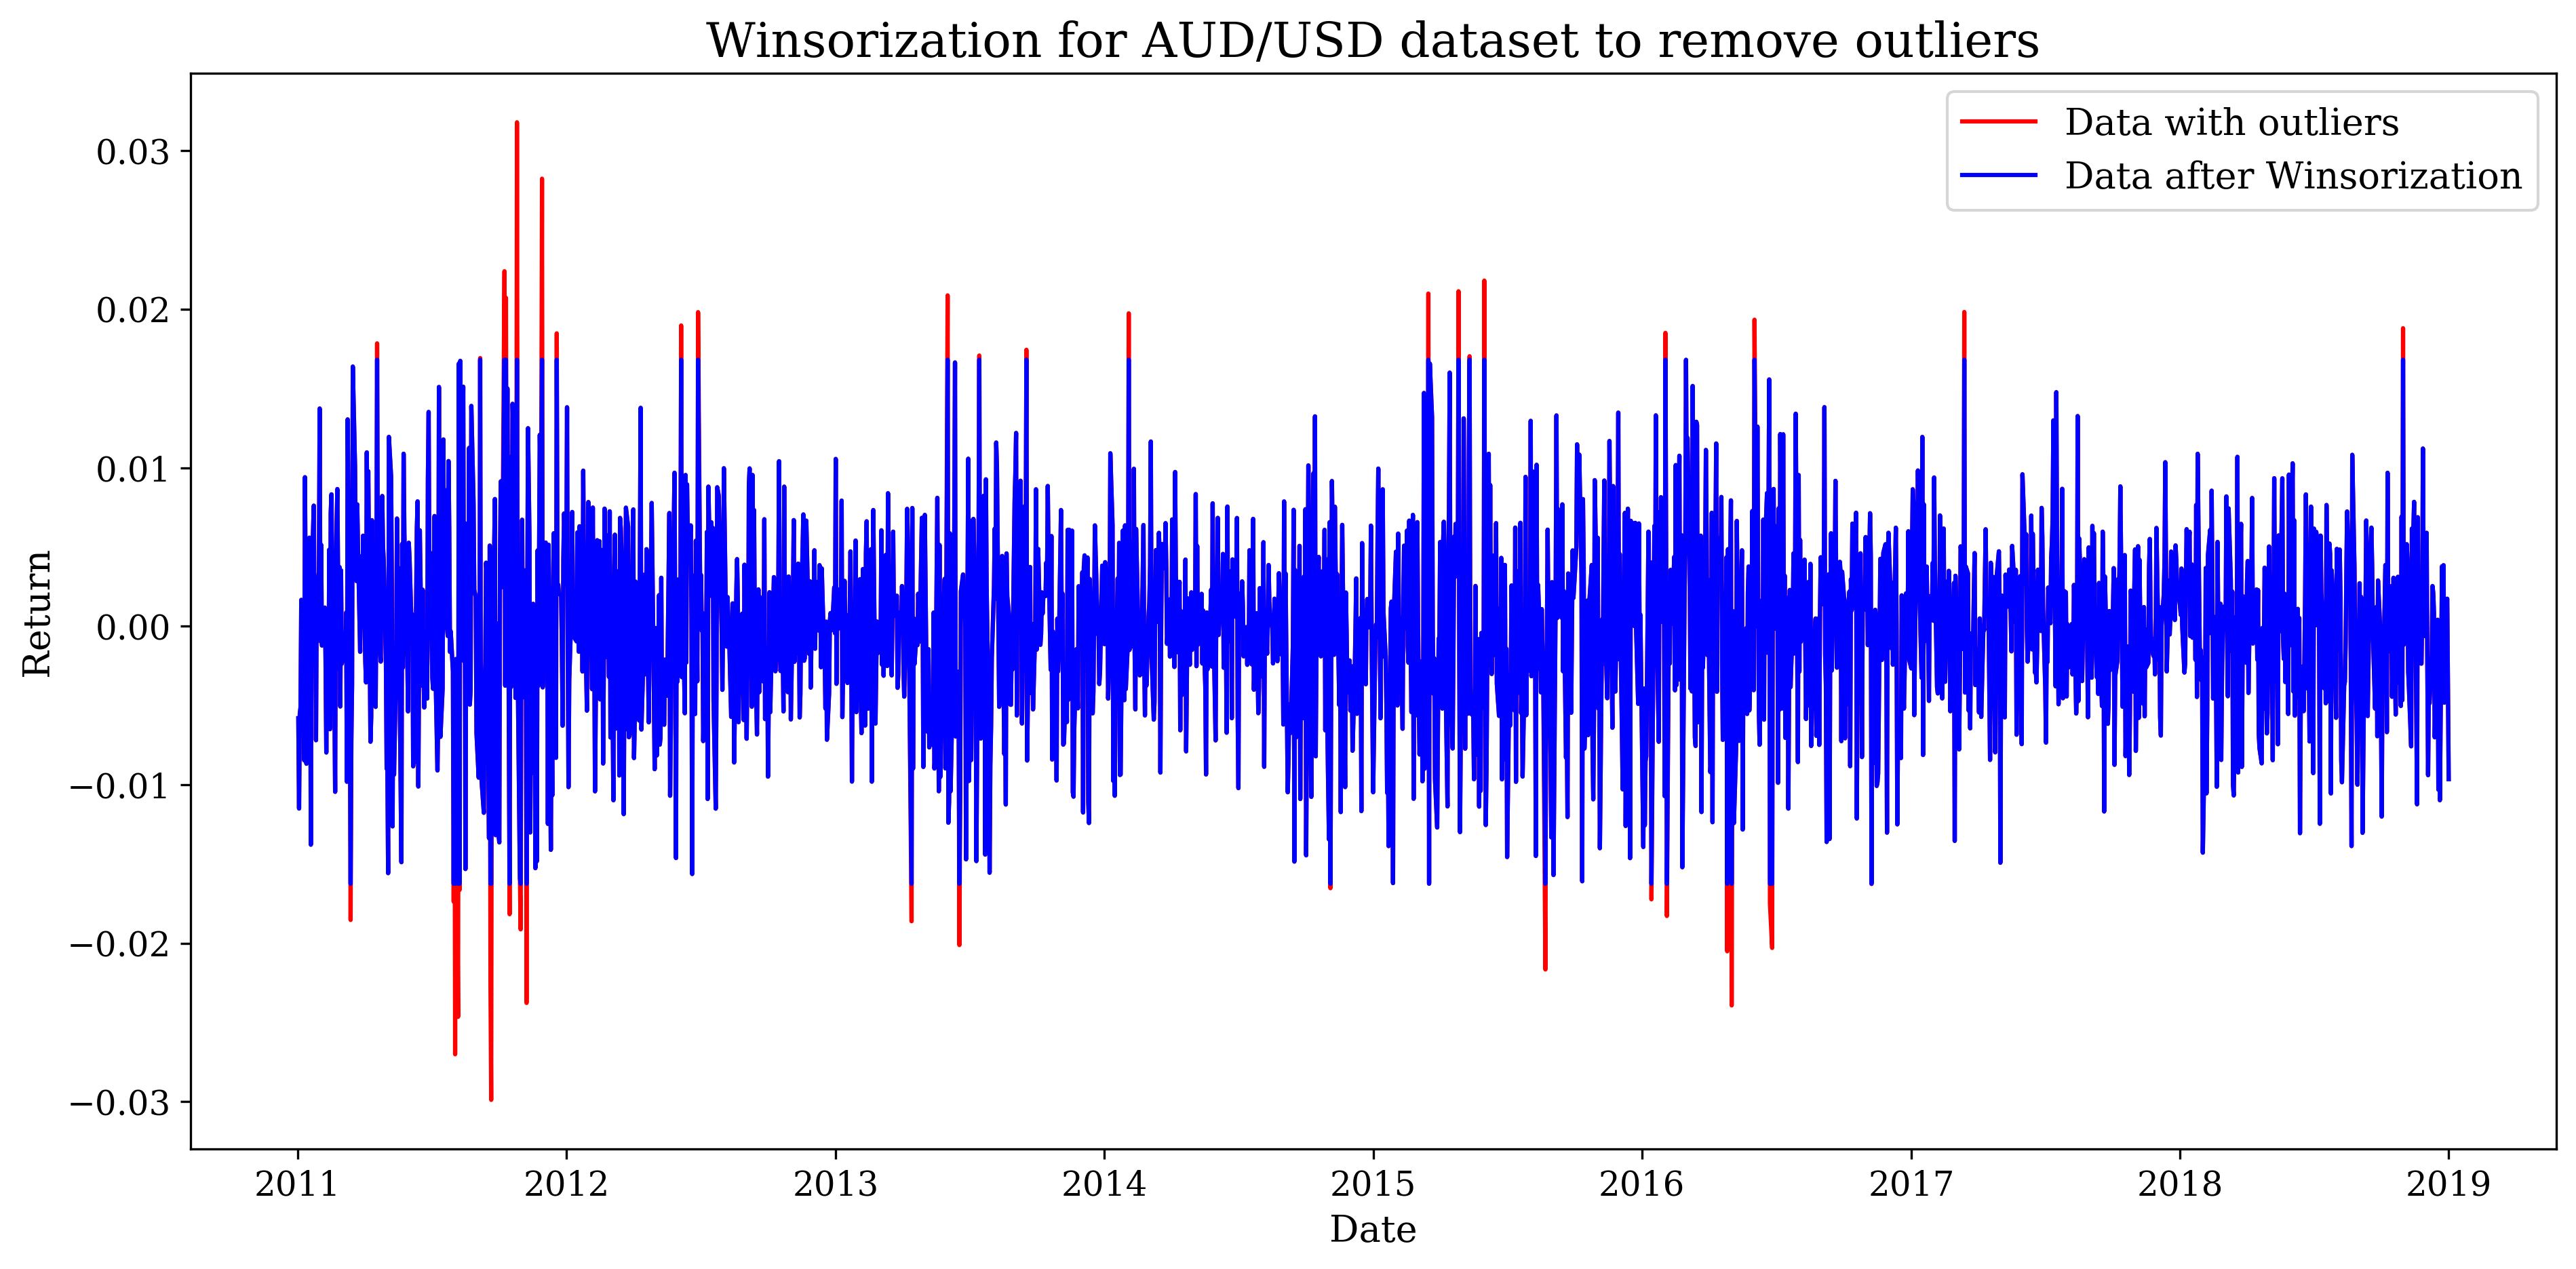

In [82]:
def plot_winsorization(df, df_winz):
    '''
    param df: dataframe of OHLC 
    '''
    fig, ax = plt.subplots(figsize=(15,7))
    ax.plot(df.index, df.Return, color='red', label='Data with outliers')
    ax.plot(df_winz.index, df_winz.Return, color='blue', label='Data after Winsorization')
    
    ax.set_title("Winsorization for AUD/USD dataset to remove outliers")
    ax.set_ylabel("Return")
    ax.set_xlabel("Date")
    
    ax.legend()
    
plot_winsorization(df, winzor_df)

It can be observed that Winsorization has allowed for the scaling back of outliers and a nice way of retaining observations within the time series.

## 5.2 Stylized Facts

This section explores different subtleties within the data to draw conclusions and facts about the AUD/USD dataset that are not apparent to the eye. This will provide a better understanding of the nuances of Forex data and possible patterns that can be extracted. The idea relies on the assumption that future price depends on historic price action and so past data can be analyzed to extra fact/patterns for future prediction.

In [84]:
#reload data and calculate log returns
df = pd.read_csv("./Data/AUDUSD_Candlestick_1_D_ASK_01.01.2011-01.01.2019.csv")

df['Date'] = pd.to_datetime(df.Date, format="%d.%m.%Y %H:%M:%S.%f")

df['Date'] = pd.DataFrame(df.Date).applymap(lambda x: x.date())

df = df.set_index(df.Date).drop(columns=['Date'])

df = df.drop_duplicates()

#Calculate simple return from closing prices
df['Return'] = df['Close'].pct_change()

df['Log Return'] = np.log(df.Close/df.Close.shift(1))

df = df.dropna()

df

Open     High      Low    Close       Volume    Return  \
Date                                                                    
2011-01-01  1.02281  1.02281  1.02281  1.02281       0.0000  0.000000   
2011-01-02  1.02070  1.02267  1.01582  1.01687   69778.4109 -0.005808   
2011-01-03  1.01687  1.01716  1.00294  1.00517  124906.5397 -0.011506   
2011-01-04  1.00517  1.00770  0.99613  0.99961  119343.0942 -0.005531   
2011-01-05  0.99961  1.00159  0.99338  0.99449   99106.5343 -0.005122   
...             ...      ...      ...      ...          ...       ...   
2018-12-27  0.70338  0.70698  0.70287  0.70412  147956.1087  0.000853   
2018-12-28  0.70412  0.70412  0.70412  0.70412       0.0000  0.000000   
2018-12-30  0.70450  0.70721  0.70334  0.70534  108426.1493  0.001733   
2018-12-31  0.70534  0.70534  0.70534  0.70534       0.0000  0.000000   
2019-01-01  0.70542  0.70554  0.69826  0.69853  190119.7498 -0.009655   

            Log Return  
Date                    
2011-01-01    0.000000  
2011-01-02   -0.005824  
2011-01-03   -0.011573  
2011-01-04   -0.005547  
2011-01-05   -0.005135  
...                ...  
2018-12-27    0.000852  
2018-12-28    0.000000  
2018-12-30    0.001731  
2018-12-31    0.000000  
2019-01-01   -0.009702  

[2521 rows x 7 columns]

In [87]:
#find correlation of normal return and log return
corr = df[['Return', 'Log Return']].corr()\

corr.head()

Return  Log Return
Return      1.000000    0.999981
Log Return  0.999981    1.000000

As shown above, the returns and log returns are highly correlated and so log returns can be used to approximate returns whilst extracting the benefits of logarithm attributes.

In [97]:
#Draw correlation heatmap
df.corr()

Open      High       Low     Close    Volume    Return  \
Open        1.000000  0.999593  0.999505  0.999171  0.008802 -0.015307   
High        0.999593  1.000000  0.999210  0.999560  0.018548  0.003723   
Low         0.999505  0.999210  1.000000  0.999545 -0.003187  0.005576   
Close       0.999171  0.999560  0.999545  1.000000  0.008004  0.024484   
Volume      0.008802  0.018548 -0.003187  0.008004  1.000000 -0.016128   
Return     -0.015307  0.003723  0.005576  0.024484 -0.016128  1.000000   
Log Return -0.015526  0.003422  0.005443  0.024264 -0.017576  0.999981   

            Log Return  
Open         -0.015526  
High          0.003422  
Low           0.005443  
Close         0.024264  
Volume       -0.017576  
Return        0.999981  
Log Return    1.000000

In [98]:
df.describe().round(4)

Open       High        Low      Close       Volume     Return  \
count  2521.0000  2521.0000  2521.0000  2521.0000    2521.0000  2521.0000   
mean      0.8699     0.8732     0.8661     0.8698  113349.1716    -0.0001   
std       0.1271     0.1275     0.1265     0.1271   89013.0184     0.0059   
min       0.6841     0.6865     0.6828     0.6865       0.0000    -0.0299   
25%       0.7561     0.7583     0.7530     0.7557   76020.3881    -0.0029   
50%       0.8213     0.8236     0.8169     0.8206  110169.2697     0.0000   
75%       1.0094     1.0135     1.0029     1.0085  144283.7107     0.0029   
max       1.1032     1.1081     1.1004     1.1025  741490.0729     0.0318   

       Log Return  
count   2521.0000  
mean      -0.0002  
std        0.0059  
min       -0.0303  
25%       -0.0029  
50%        0.0000  
75%        0.0028  
max        0.0313

c:\users\arkaean\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


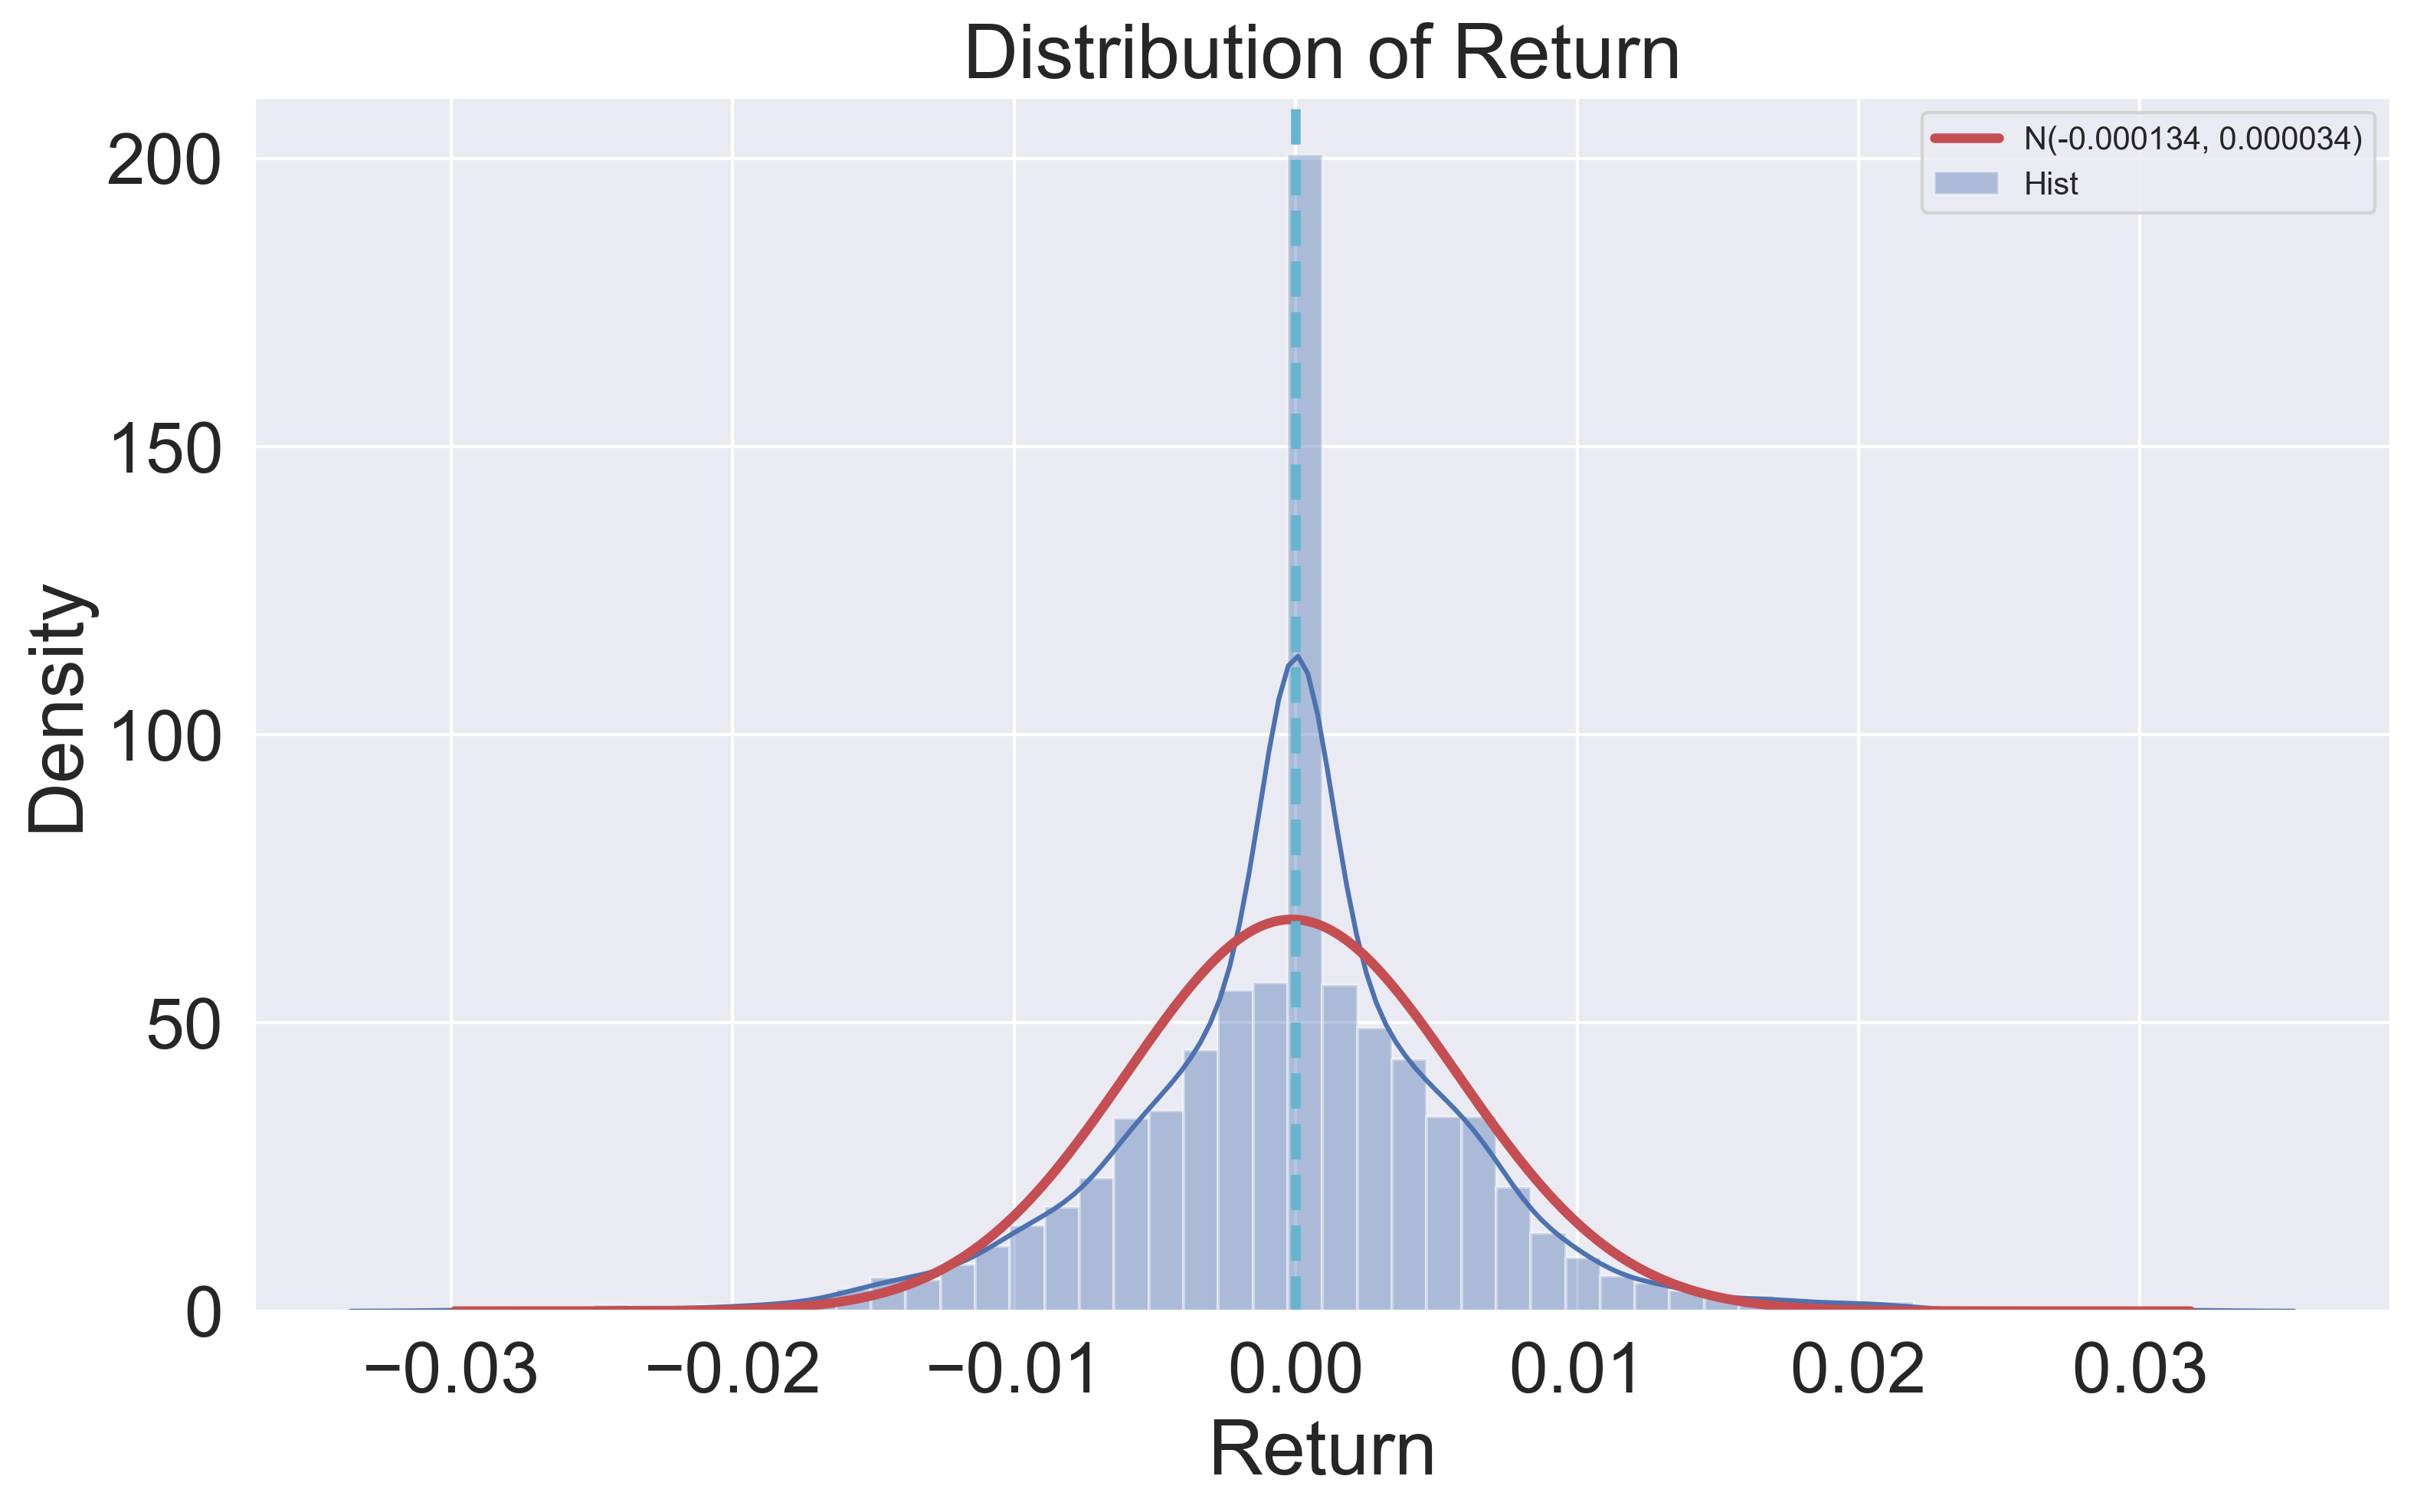

In [109]:

#Function to extract statistics for drawing probability density function + histogram
def statistical_properties(feature):
    properties = feature.describe()
    mean = properties['mean']
    std = properties['std']
    rtn = np.linspace(properties['min'], properties['max'], num=1000)
    pdf = scs.norm.pdf(rtn, loc=mean, scale=std)
    return mean, std, rtn, pdf

#Draw PDF and Histogram for given feature
def pdf_histogram(feature, xlim=(-0.2, 0.2)):
    
    fig, ax = plt.subplots(figsize=(12, 7))

    mean, std, rtn, pdf = statistical_properties(feature)
    
    sns.distplot(feature, kde=True, norm_hist=True, label='Hist')
    
    ax.plot(rtn, pdf, 'r', lw=3, 
             label=f'N({mean:.6f}, {std**2:.6f})')
    ax.axvline(x=0, c='c',linestyle='--', lw=3)
    ax.set_title(f'Distribution of {feature.name}', fontsize=24)
    ax.legend(loc='upper right', fontsize = 10);
    
pdf_histogram(df["Return"])

c:\users\arkaean\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


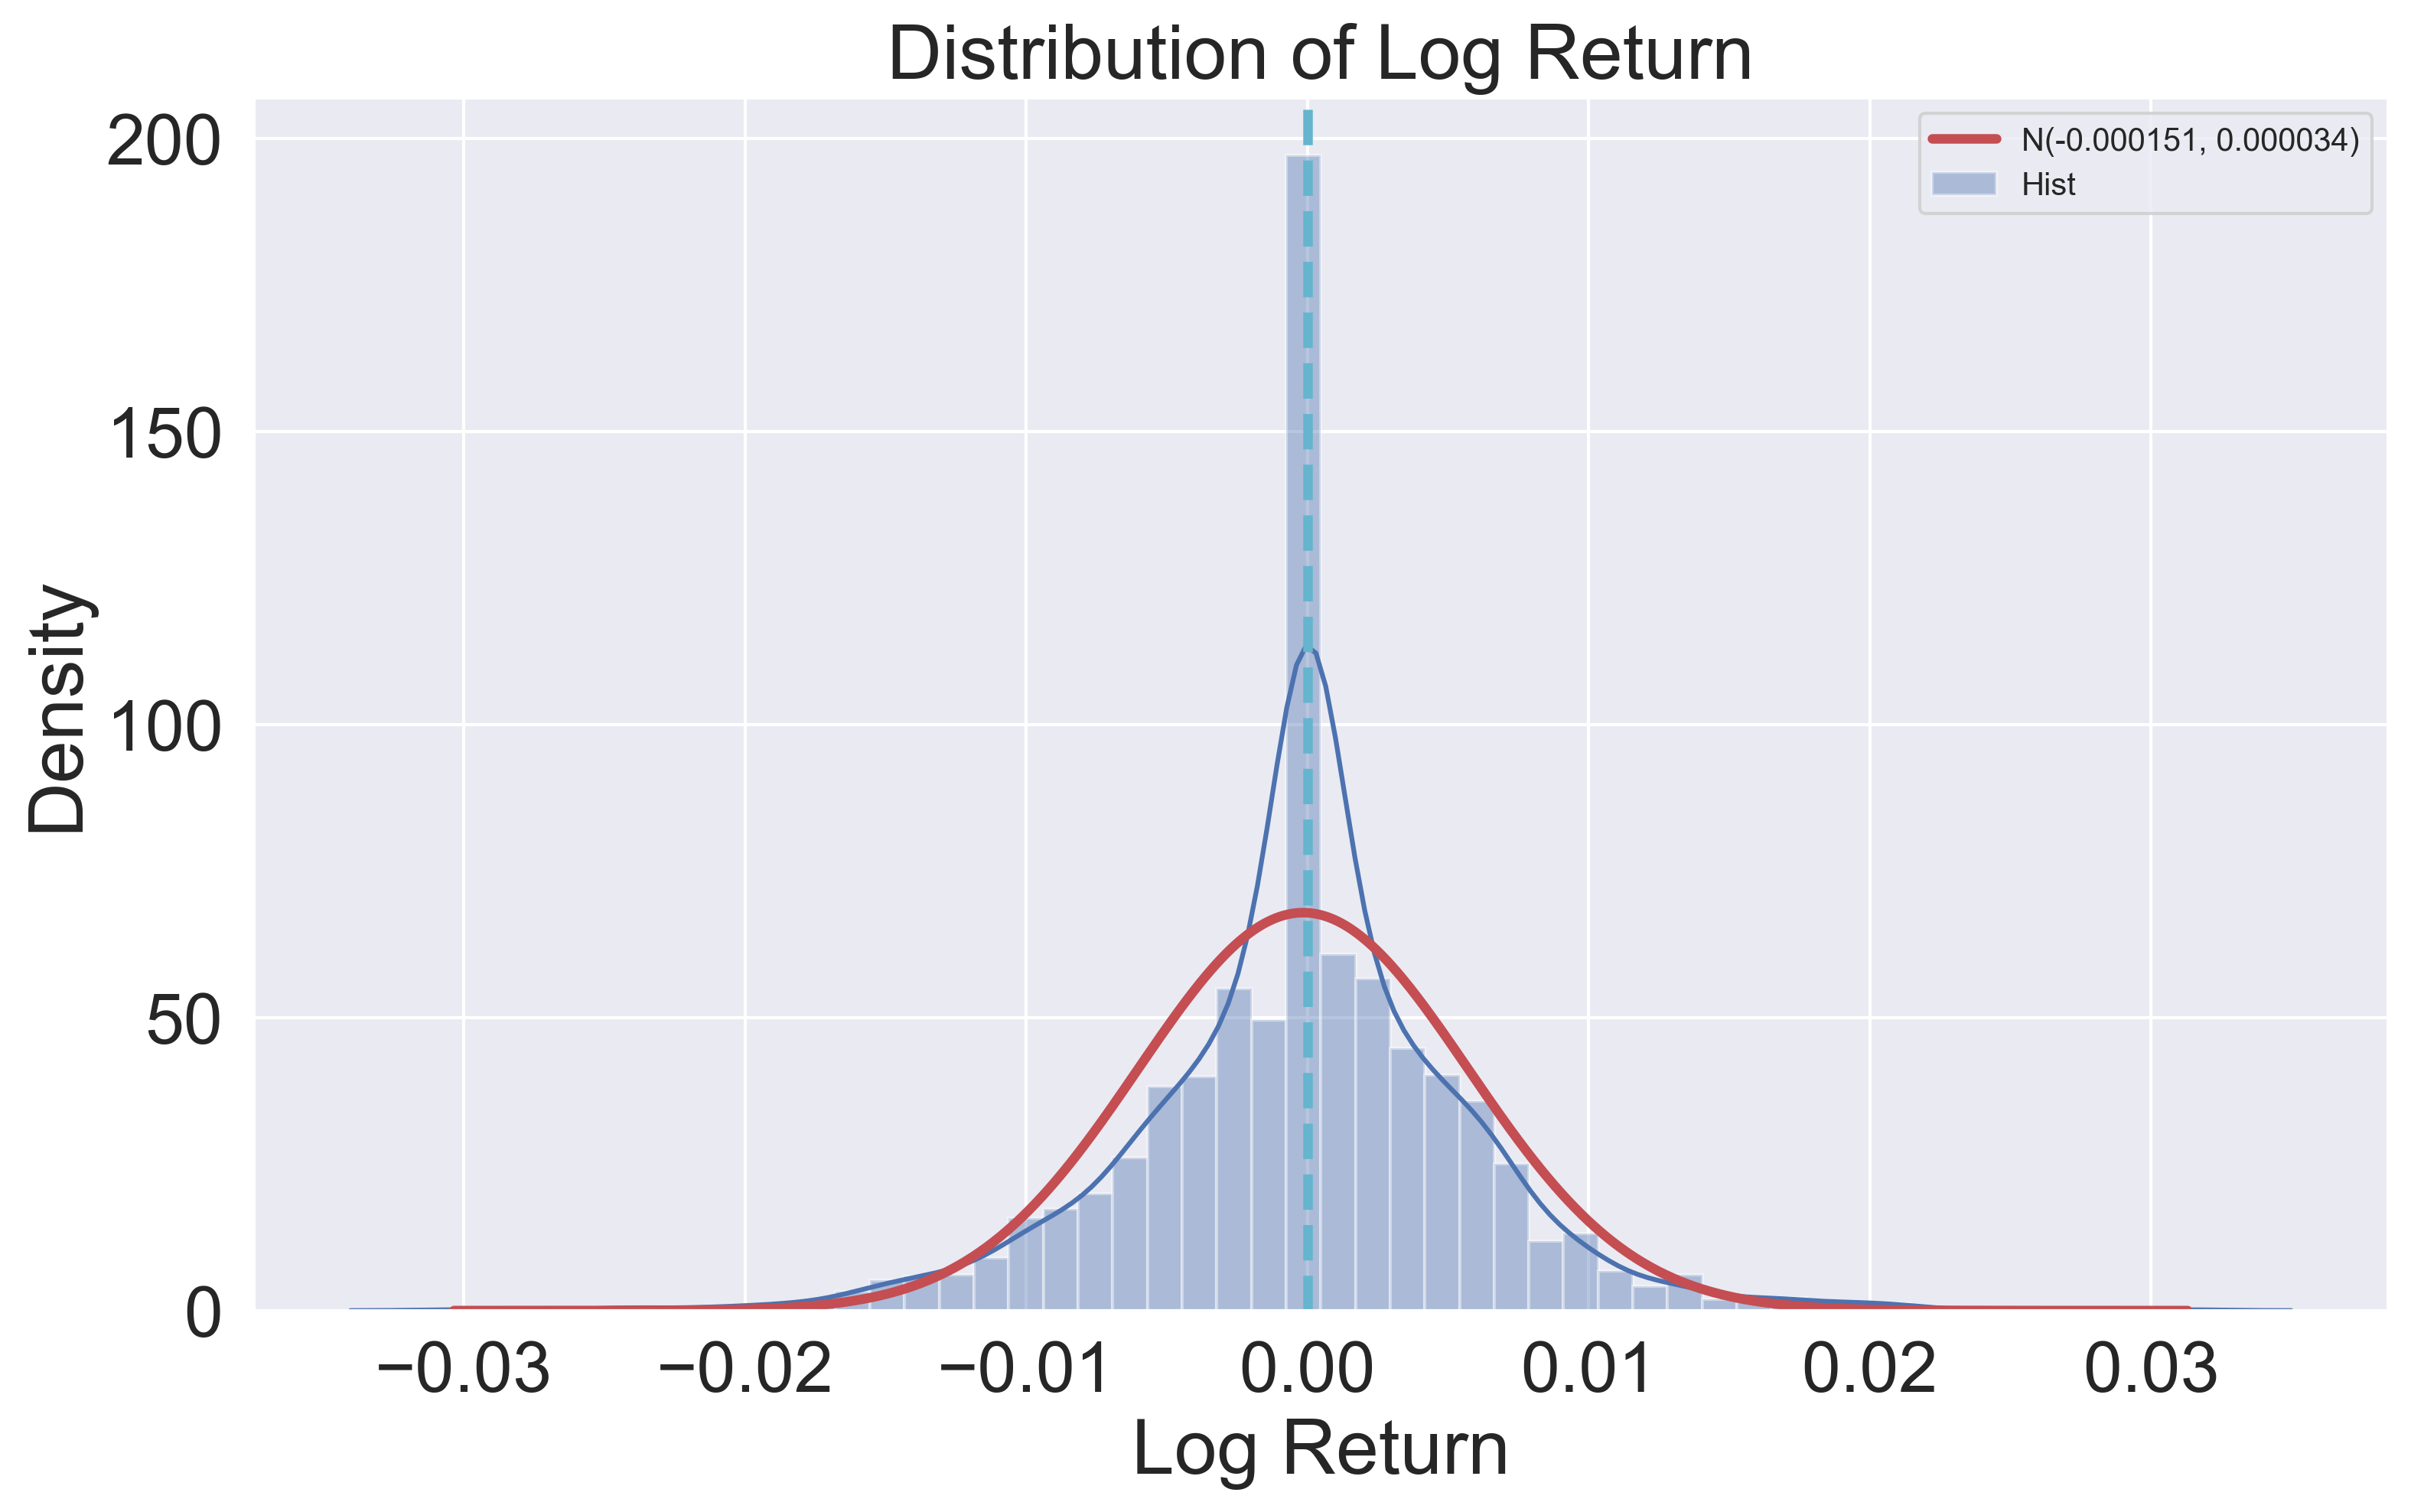

In [110]:
pdf_histogram(df["Log Return"])

c:\users\arkaean\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


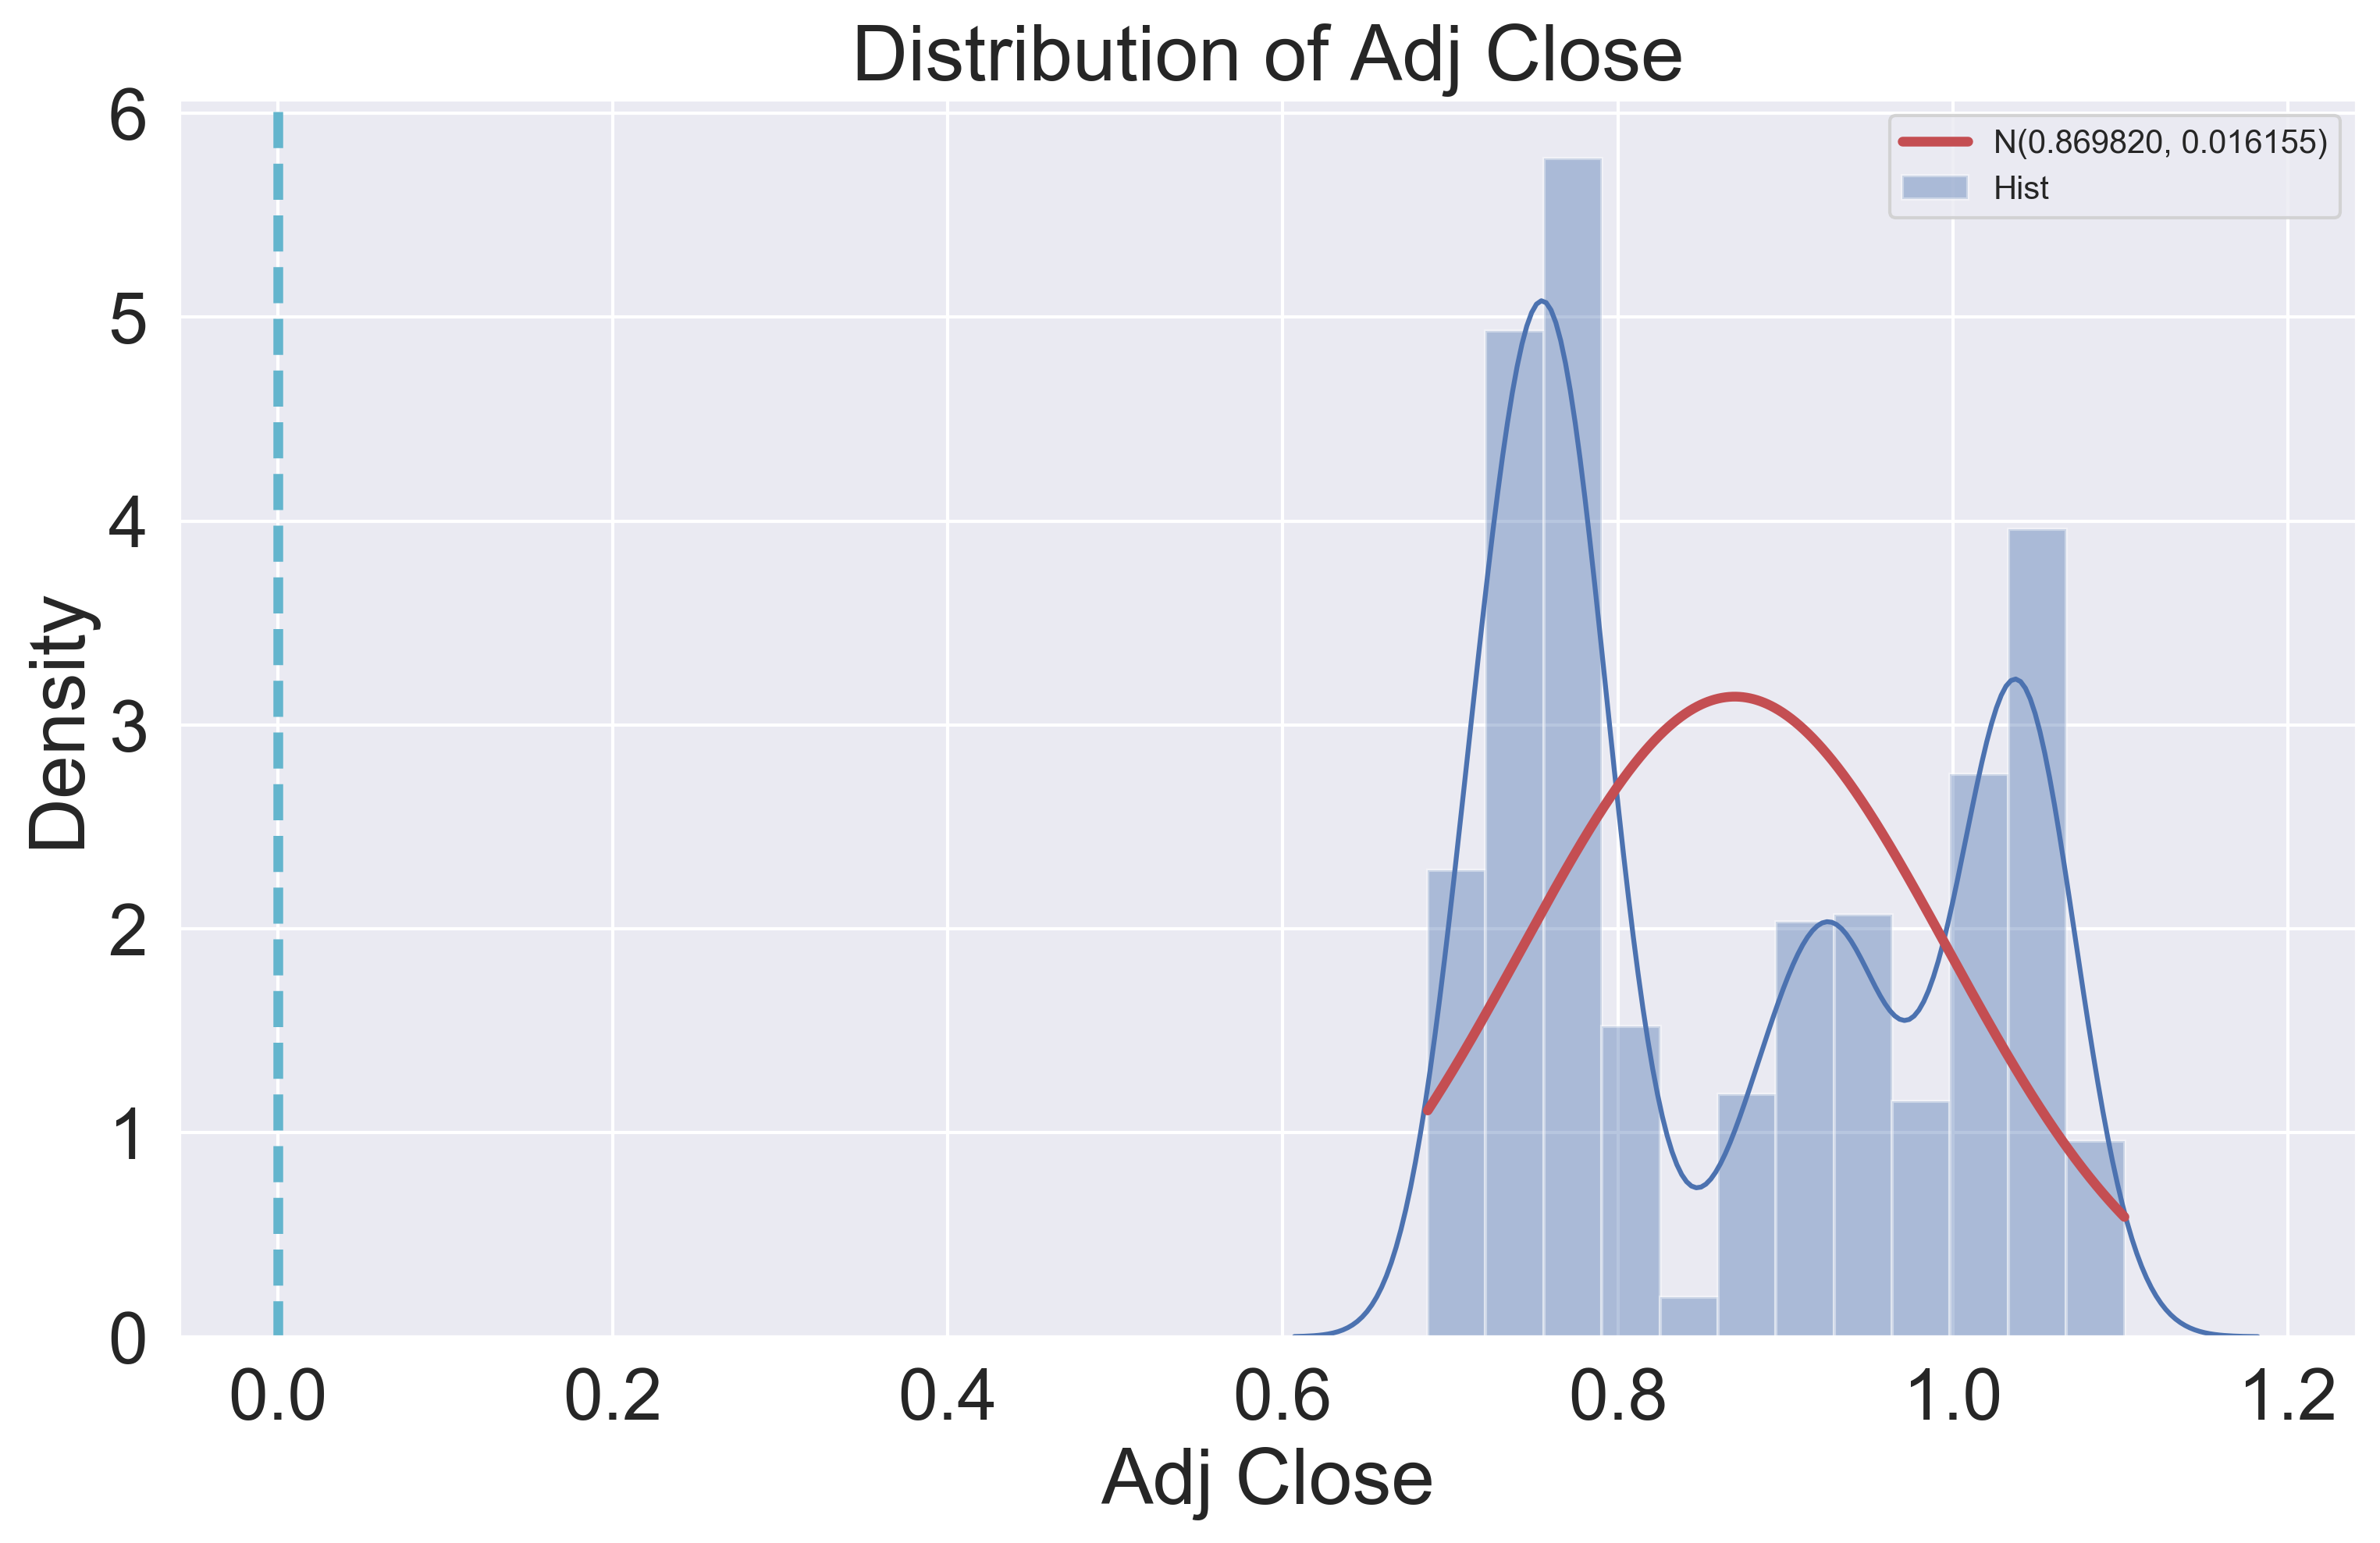

In [112]:
df['Adj Close'] = df.Close
pdf_histogram(df['Adj Close'])

Calculate Kurtosis and Skewness values to understand distribution of data relative to normality.

In [115]:
def normality_test(df):
    properties = pd.DataFrame({'skew':scs.skew(df),
                 'kurtosis': scs.kurtosis(df),
                 'normal_test (p-val)' : scs.normaltest(df)[1]},
                  index = df.columns)
    return properties

#test kurtosis and skew for returns, log returns and raw price
norm_r = normality_test(pd.DataFrame(df['Return']))
norm_log = normality_test(pd.DataFrame(df['Log Return']))
norm_adj = normality_test(pd.DataFrame(df['Adj Close']))
norm_test = pd.concat([norm_adj, norm_r, norm_log])
norm_test

skew  kurtosis  normal_test (p-val)
Adj Close   0.272847 -1.529002         0.000000e+00
Return     -0.069047  2.321321         8.535517e-32
Log Return -0.107018  2.318565         2.296172e-32

Aggregational Gaussianity tests with lagged series for log returns feature

In [118]:
#generating lagged series of log returns
df_lags = pd.DataFrame(df['Adj Close'])

for feat in range(1, 6):
    
    df_lags[f'log_rtn_{feat}'] = np.log(df_lags['Adj Close']/df_lags['Adj Close'].shift(feat))

df_lags.dropna(inplace=True)
df_lags

Adj Close  log_rtn_1  log_rtn_2  log_rtn_3  log_rtn_4  log_rtn_5
Date                                                                        
2011-01-06    0.99614   0.001658  -0.003477  -0.009024  -0.020597  -0.026421
2011-01-07    0.99614   0.000000   0.001658  -0.003477  -0.009024  -0.020597
2011-01-09    0.99572  -0.000422  -0.000422   0.001236  -0.003899  -0.009446
2011-01-10    0.98729  -0.008502  -0.008924  -0.008924  -0.007266  -0.012401
2011-01-11    0.99657   0.009356   0.000853   0.000432   0.000432   0.002089
...               ...        ...        ...        ...        ...        ...
2018-12-27    0.70412   0.000852  -0.003983  -0.000142  -0.002751   0.001023
2018-12-28    0.70412   0.000000   0.000852  -0.003983  -0.000142  -0.002751
2018-12-30    0.70534   0.001731   0.001731   0.002584  -0.002252   0.001589
2018-12-31    0.70534   0.000000   0.001731   0.001731   0.002584  -0.002252
2019-01-01    0.69853  -0.009702  -0.009702  -0.007971  -0.007971  -0.007118

[2516 rows x 6 columns]

c:\users\arkaean\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\arkaean\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\arkaean\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use e

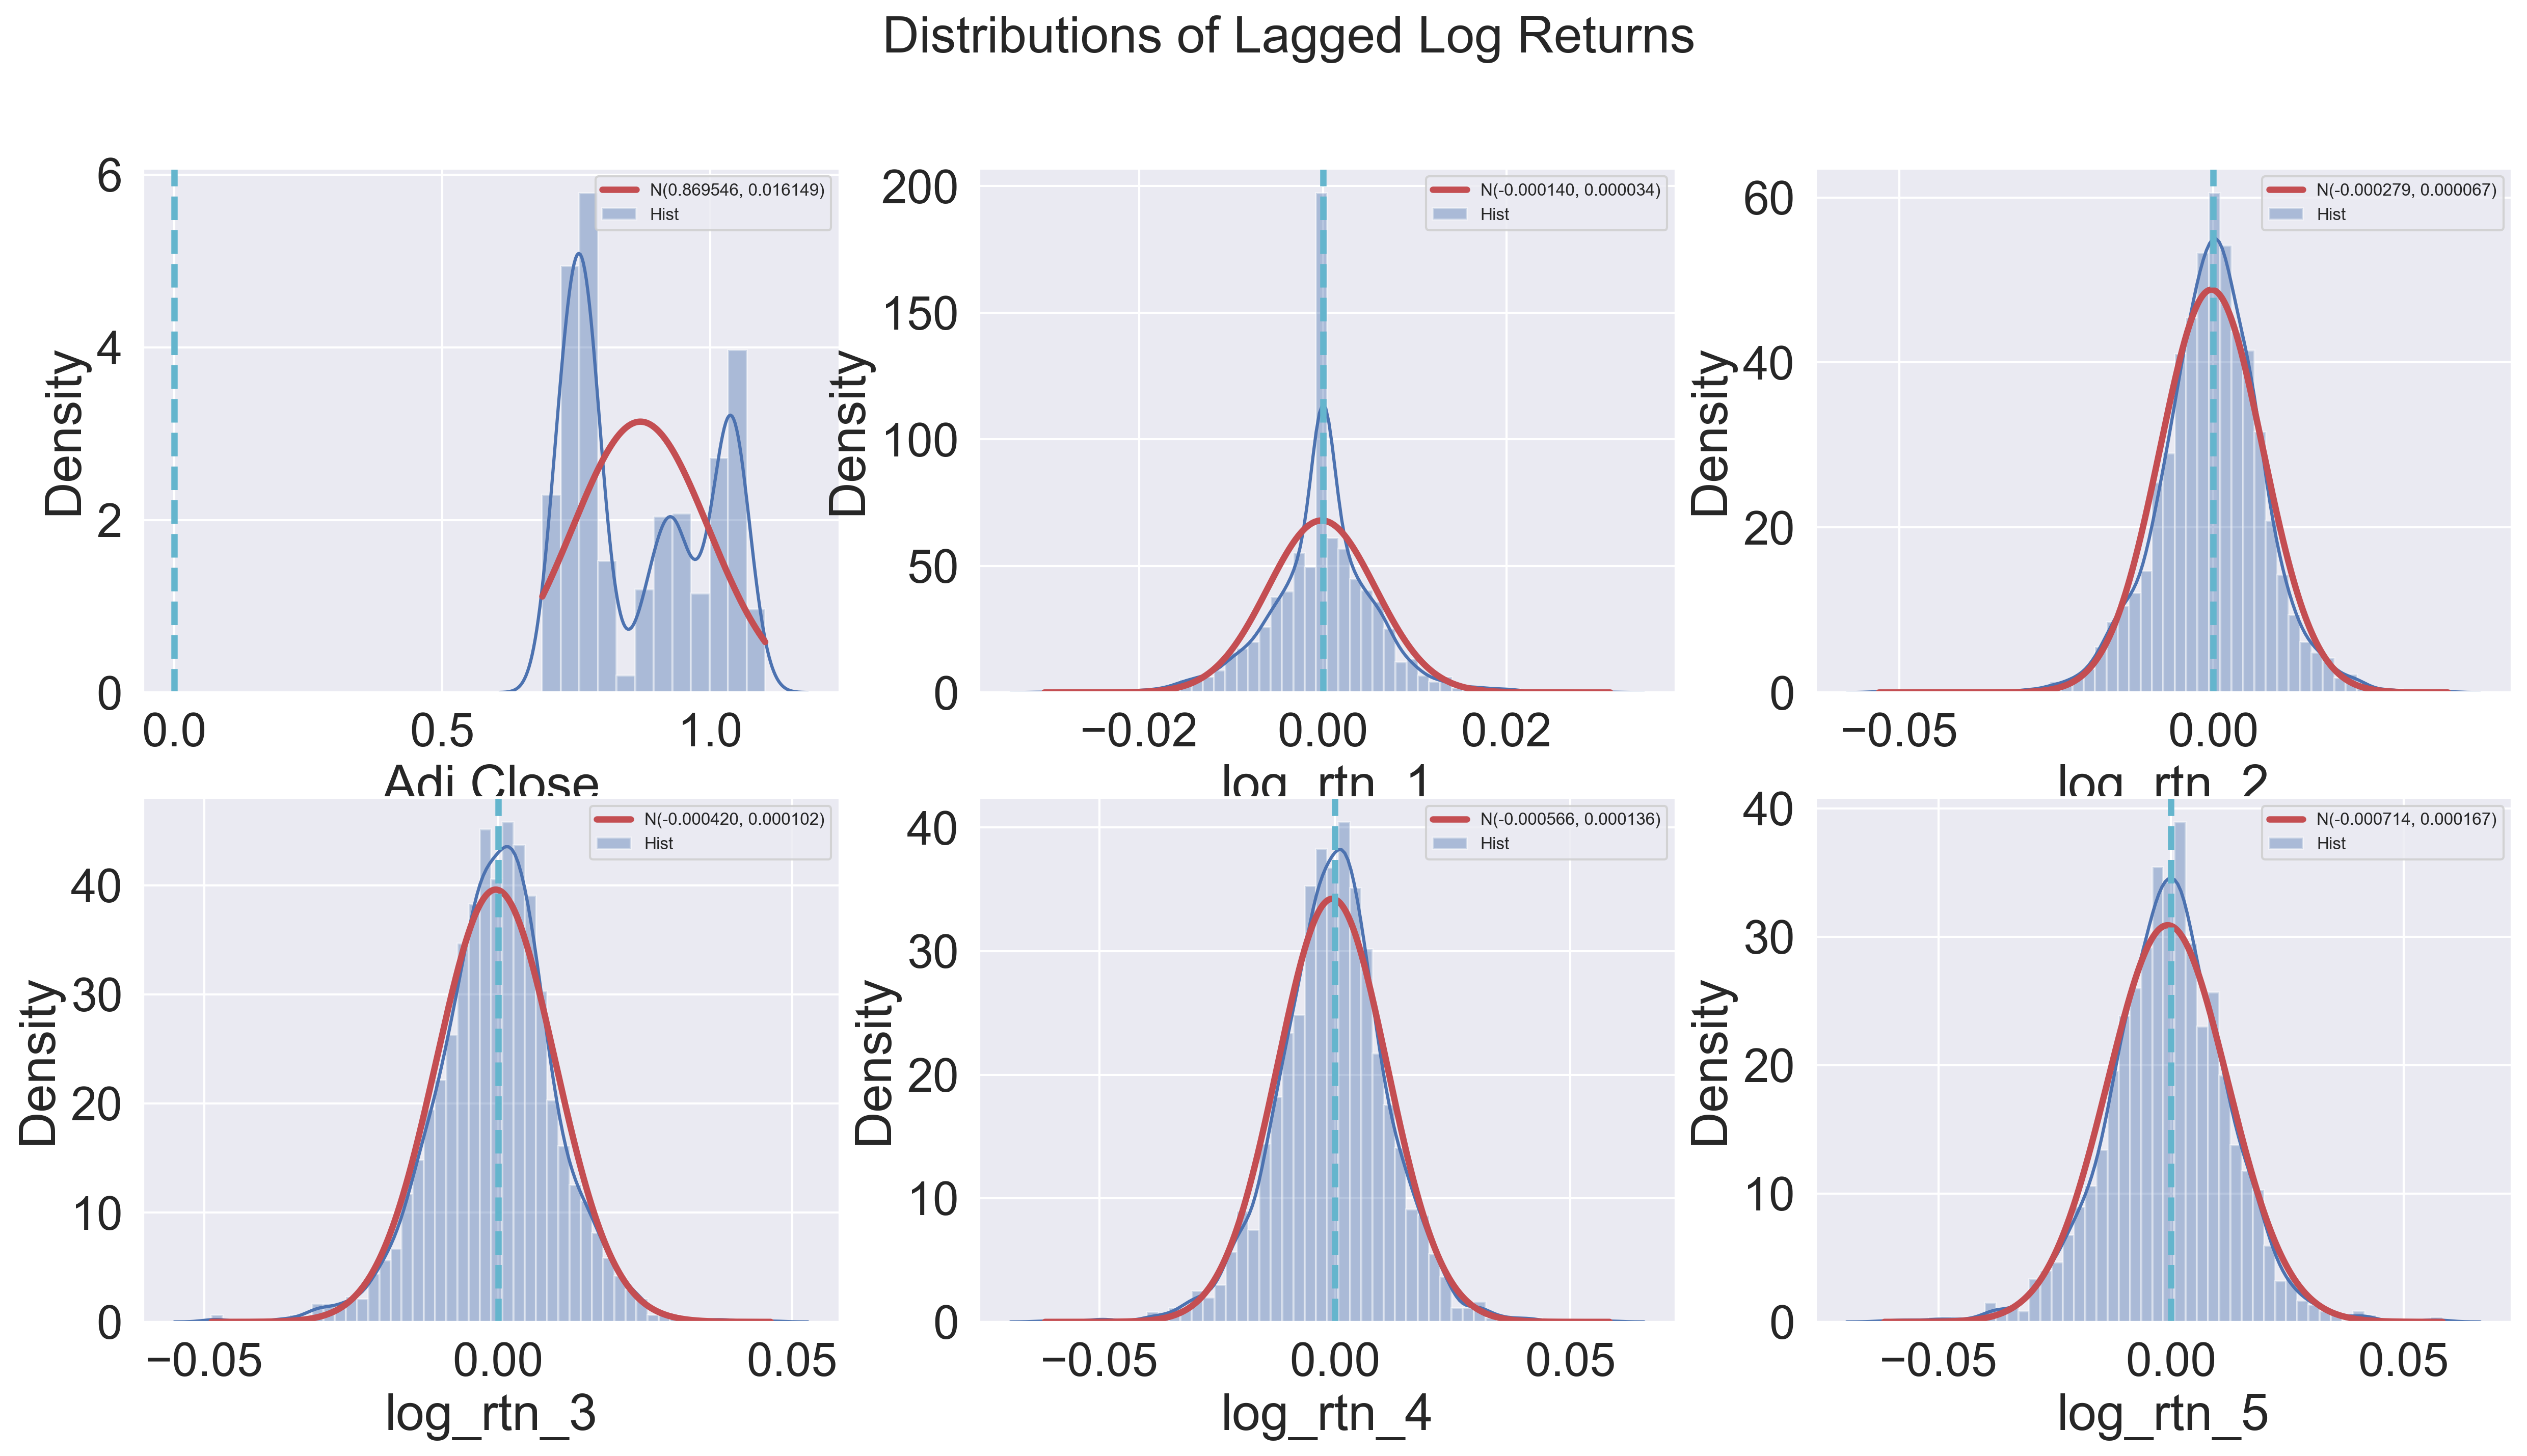

In [120]:
#draw the histogram with Probability Density Function
fig, axs = plt.subplots(2,3, figsize=(20,10))
fig.suptitle(f'Distributions of Lagged Log Returns', fontsize=24)
plt.rcParams.update({'font.size': 8})

def pdf_AG_mutliplot(col, i, j):

    mean, std, rtn, pdf = statistical_properties(col)
    sns.distplot(col, kde=True, norm_hist=True, label='Hist', ax=axs[i,j])
    axs[i,j].plot(rtn, pdf, 'r', lw=3, label=f'N({mean:.6f}, {std**2:.6f})')
    axs[i,j].axvline(x=0, c='c',linestyle='--', lw=3)
    axs[i,j].legend(loc='upper right', fontsize=8);

pdf_AG_mutliplot(df_log_rtn['Adj Close'], 0, 0)
pdf_AG_mutliplot(df_log_rtn['log_rtn_1'], 0, 1)
pdf_AG_mutliplot(df_log_rtn['log_rtn_2'], 0, 2)
pdf_AG_mutliplot(df_log_rtn['log_rtn_3'], 1, 0)
pdf_AG_mutliplot(df_log_rtn['log_rtn_4'], 1, 1)
pdf_AG_mutliplot(df_log_rtn['log_rtn_5'], 1, 2)


Seasonal decompose data to analyse basic trends and seasonal components

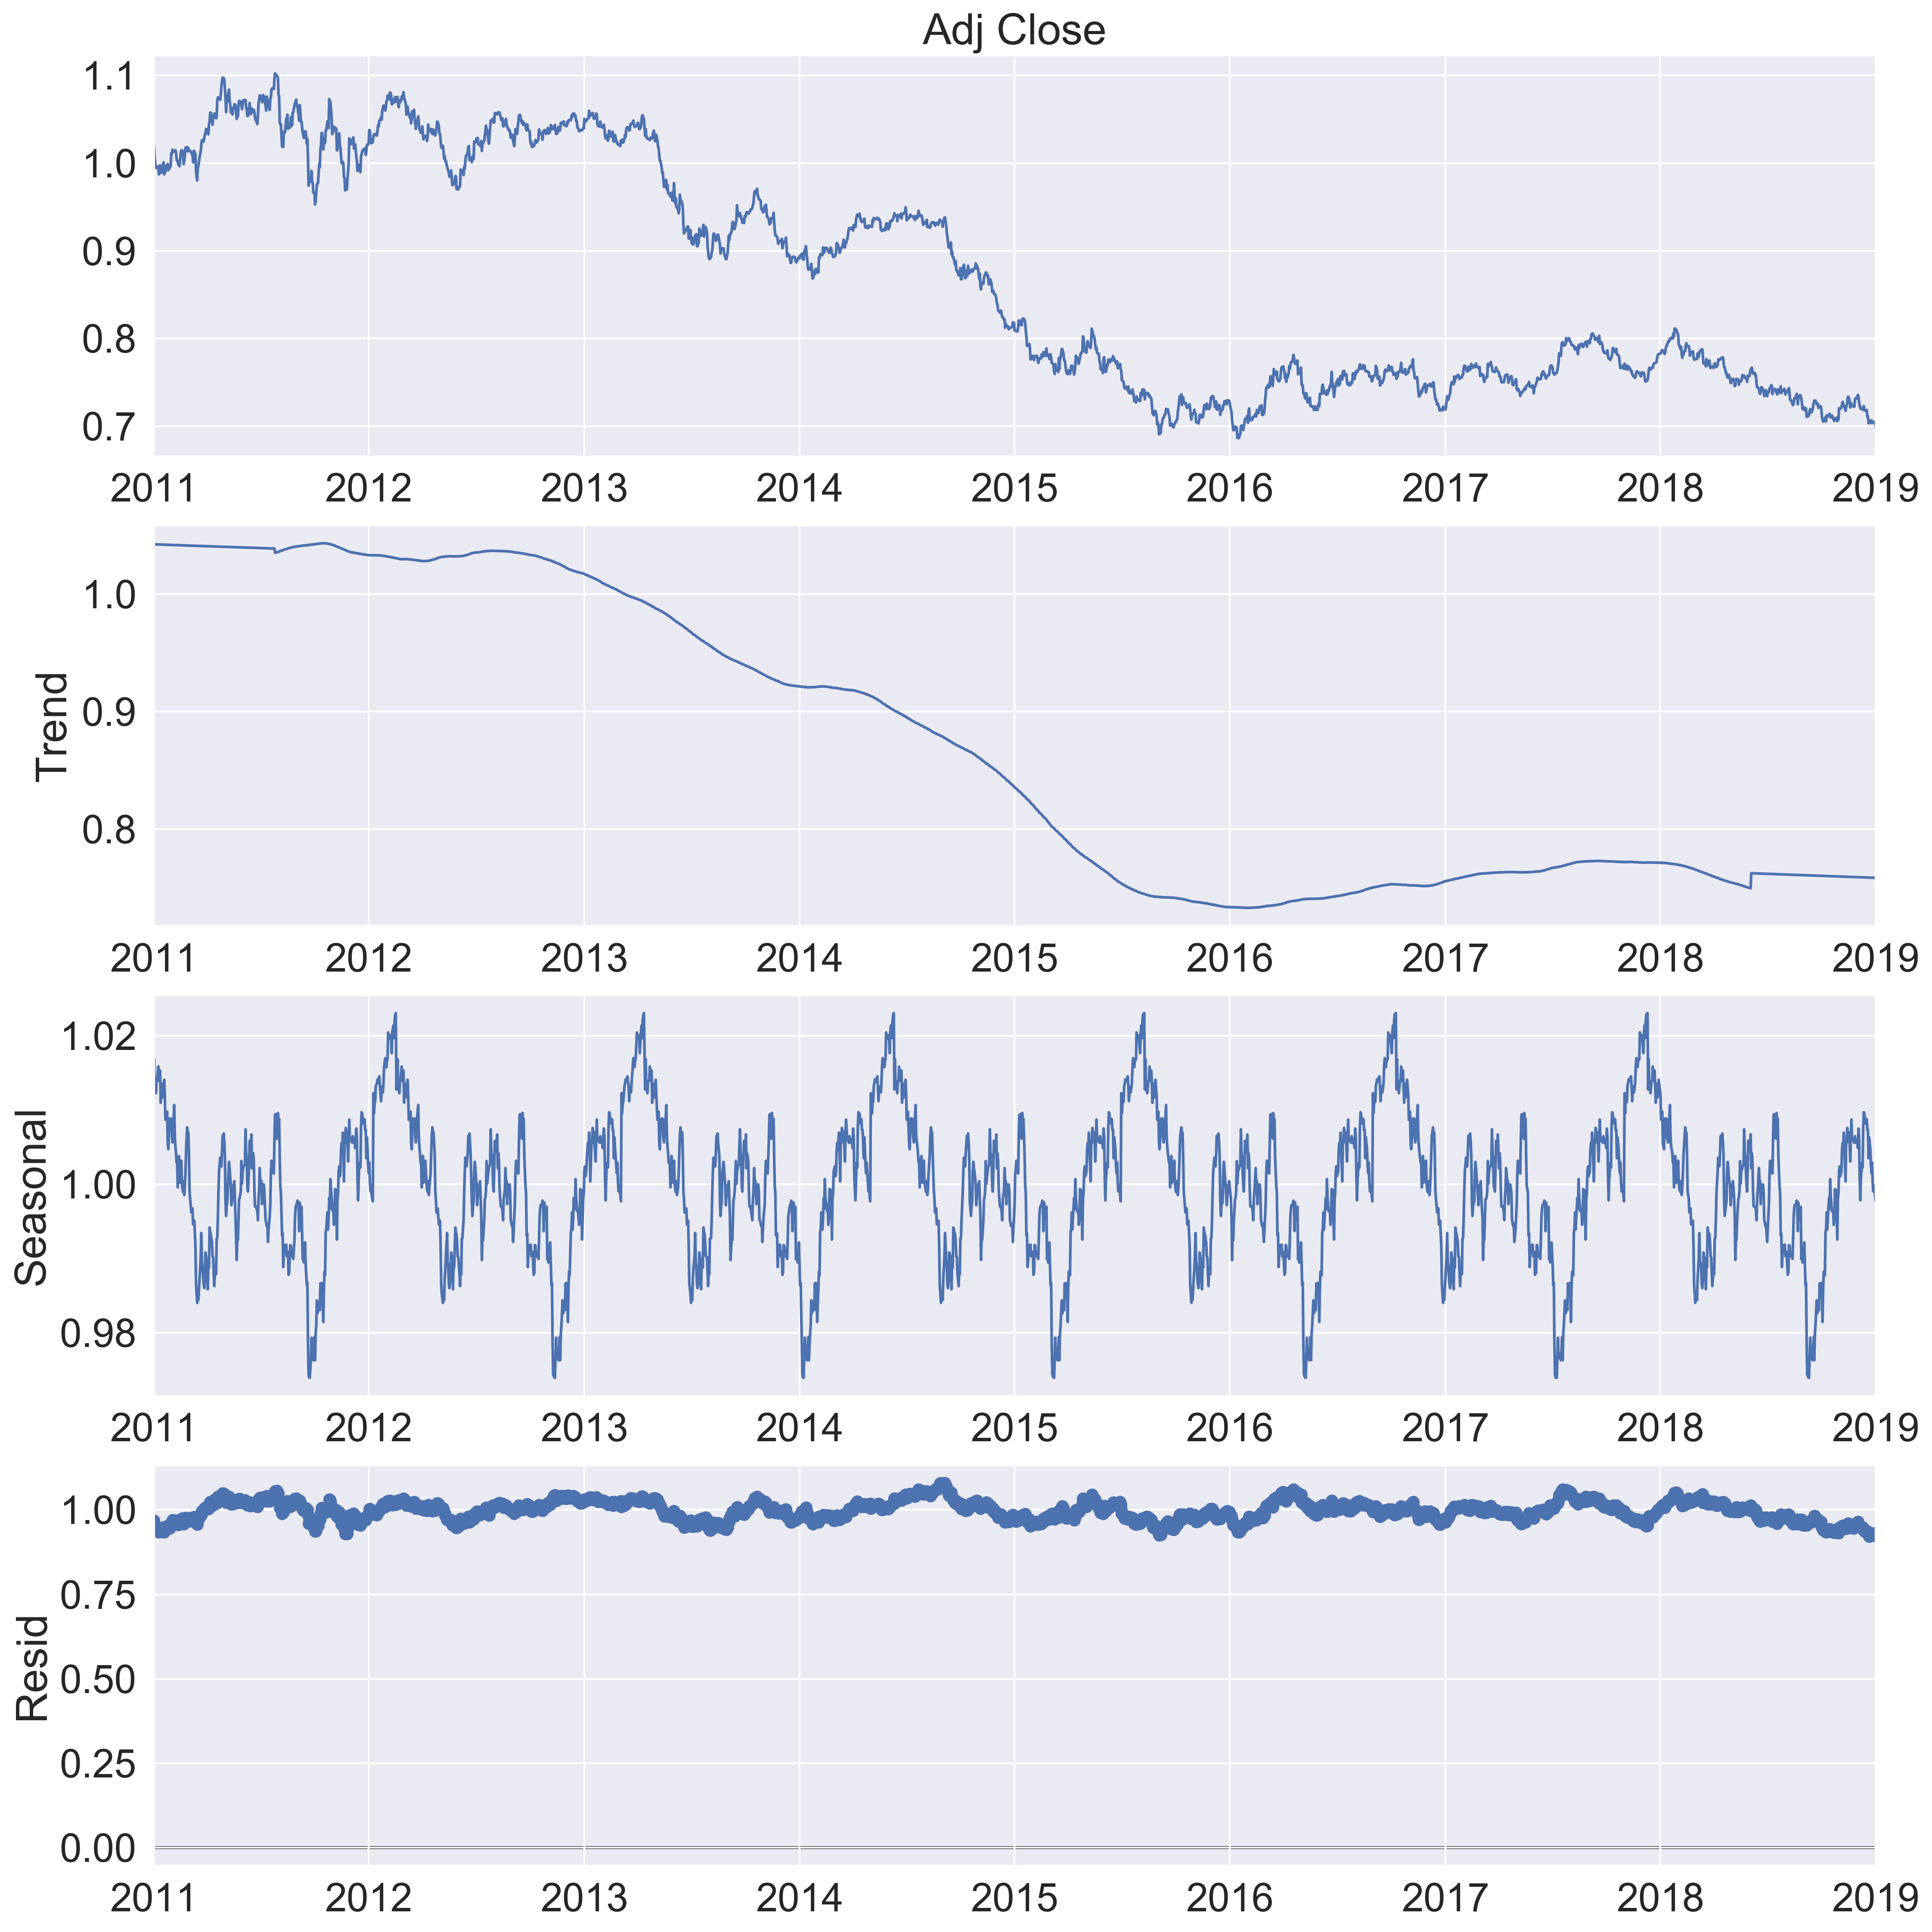

In [123]:
from statsmodels.tsa.seasonal import seasonal_decompose

data_decomp = seasonal_decompose(df['Adj Close'], model="multiplicative", extrapolate_trend='freq', period=365)

plt.rcParams.update({'figure.figsize': (15,15)})

data_decomp.plot()

plt.show()

Autocorrelation and Partial Autocorrelation plots to understand how lags can be used to predict future prices

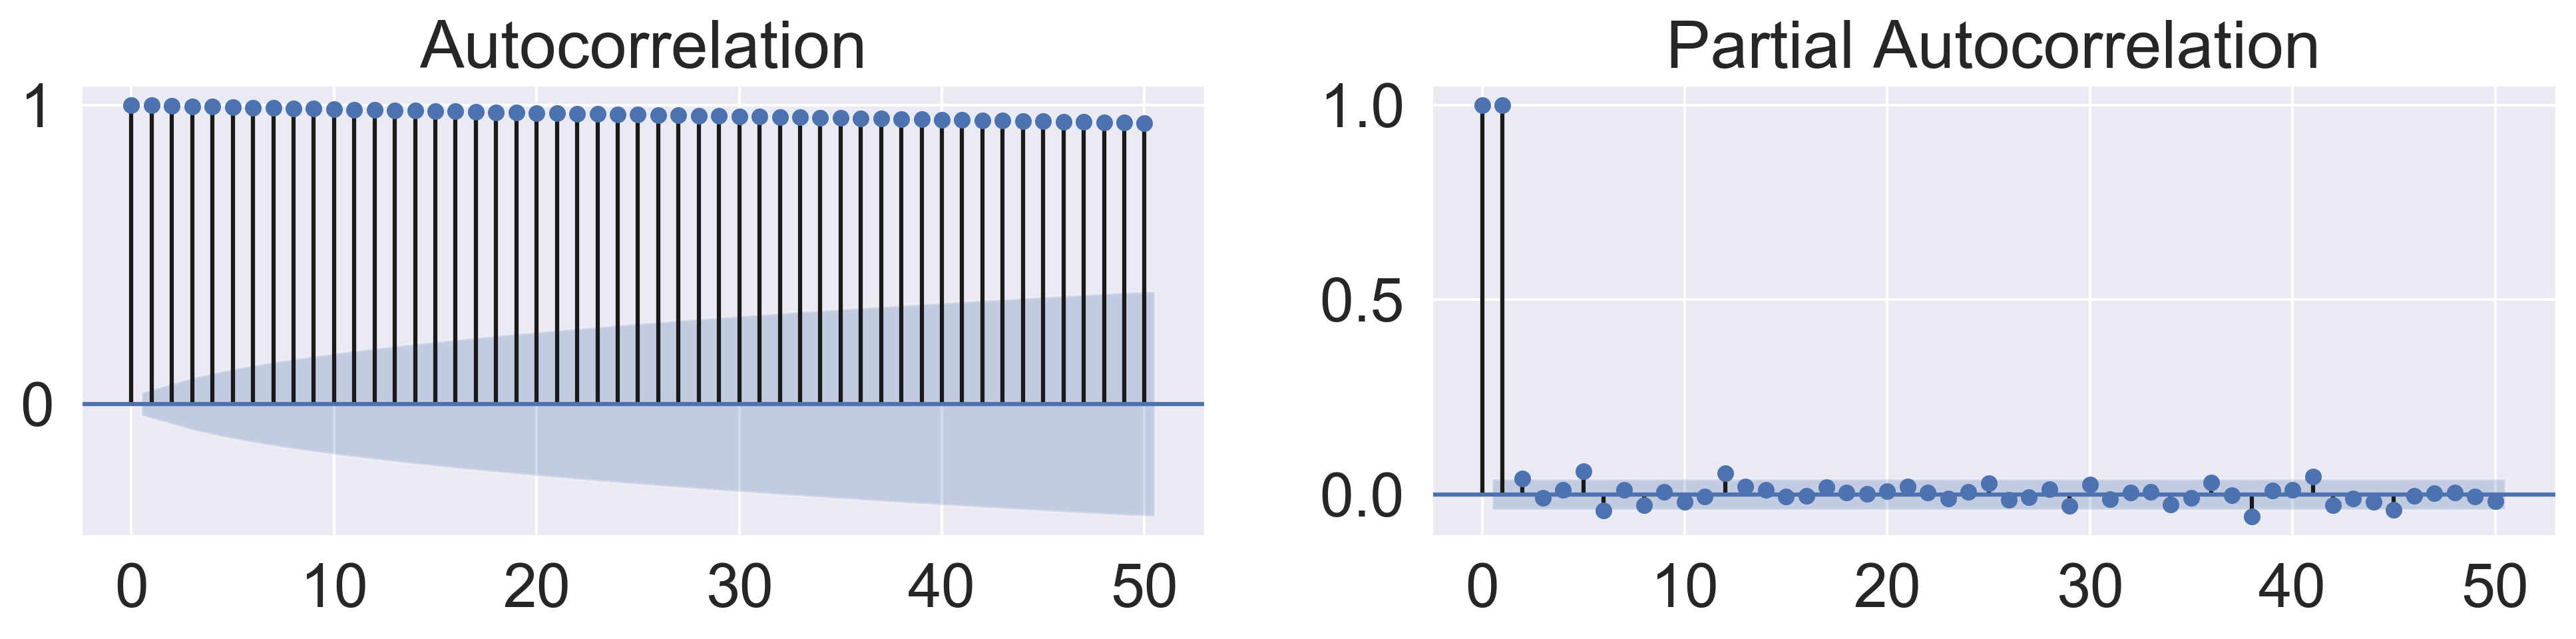

In [124]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#Autocorrelation and Partial-Autocorrelaation Plots
def acf_pcf(close, lags):

    fig, ax = plt.subplots(1,2,figsize=(16,3))

    plot_acf(close.tolist(), lags=lags, ax=ax[0])
    
    plot_pacf(close.tolist(), lags=lags, ax=ax[1])
        
    plt.show()
    
acf_pcf(df['Adj Close'], 50)

In [38]:
#Function to remove feature through manual feature selection by cross correlation values
def correlation(dataset, threshold):
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname] # deleting the column from the dataset

    return dataset

removed_corr = correlation(test, 0.8)

print(removed_corr.shape)

removed_corr.head()

(4606, 21)


HAOpen        a0        a1         w      a0.1  \
Date                                                                    
2003-06-10 21:00:00  1.149563 -0.000923  0.001329  1.573803  0.000947   
2003-06-11 21:00:00  1.154866 -0.000390  0.003691  1.442575  0.000528   
2003-06-12 21:00:00  1.161060  0.000653 -0.004720  1.168226  0.000538   
2003-06-15 21:00:00  1.158971  0.000512 -0.002440  1.171743  0.000425   
2003-06-16 21:00:00  1.161542  0.000450  0.002454  1.199813  0.000555   

                         a1.1      b1.1       w.1      a1.2      b1.2  ...  \
Date                                                                   ...   
2003-06-10 21:00:00  0.000037 -0.001151  0.854785 -0.000732  0.002001  ...   
2003-06-11 21:00:00 -0.002163 -0.002535  1.236011  0.000644  0.002080  ...   
2003-06-12 21:00:00 -0.002558  0.003173  1.162189  0.000891  0.002629  ...   
2003-06-15 21:00:00  0.001967  0.002172  0.765915  0.003059 -0.000155  ...   
2003-06-16 21:00:00  0.004102 -0.000703  1.158018  0.001510 -0.002128  ...   

                         WADClose  MomentumOpen  MomentumClose  \
Date                                                             
2003-06-10 21:00:00   5350.424298      -0.01643        0.00420   
2003-06-11 21:00:00  11770.971596       0.00489        0.00477   
2003-06-12 21:00:00  25187.732714       0.00506        0.01871   
2003-06-15 21:00:00  15448.699240       0.01948        0.00935   
2003-06-16 21:00:00   7730.476173       0.00957        0.00299   

                     MomentumOpen.2  MomentumOpen.3  StochClose  StochClose.3  \
Date                                                                            
2003-06-10 21:00:00        -0.00619        -0.00945   66.177606     44.073066   
2003-06-11 21:00:00         0.00794         0.00280   71.563981     52.506801   
2003-06-12 21:00:00        -0.00737         0.00156   93.433653     91.061018   
2003-06-15 21:00:00         0.01754         0.01329   58.876004     69.174189   
2003-06-16 21:00:00         0.01240         0.01751   30.301455     50.589536   

                        ROC.1   Slope.5       Volume  
Date                                                  
2003-06-10 21:00:00 -0.732957  0.001702  1069002.992  
2003-06-11 21:00:00 -0.009350  0.001450  1066536.096  
2003-06-12 21:00:00 -0.170828  0.001234  1051470.307  
2003-06-15 21:00:00  0.565039  0.001145  1056294.303  
2003-06-16 21:00:00  0.209022  0.001065  1064582.492  

[5 rows x 21 columns]